# Analysing the Data on AI, ML, DS & Big Data Jobs 

* Great resource thank you for sharing
* Note for interpretation: dataset have slight geo-restricted bias (exp; only have one entry for Ireland) 

## Summary of Content
* Preprocessing for missing value handling
* Feature extraction: Country, city, skill requirements extracted from dataset to enable individual evaluation
* Visualisation of Individual features based on frequencies
* Visualisation inbetween features for evaluation cross interactions
* Association rule mining to extract frequent required skill sets

## Data preprocessing & transformation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re

In [2]:
data=pd.read_csv('data_science_job.csv',encoding='ISO-8859-1')

In [3]:
data.head(2)

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,Entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,"
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,Entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,"


In [4]:
data.shape

(3198, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Company                     3197 non-null   object
 1   Job Title                   3197 non-null   object
 2   Location                    3197 non-null   object
 3   Job Type                    3197 non-null   object
 4   Experience level            2962 non-null   object
 5   Salary                      3009 non-null   object
 6   Requirment of the company   3198 non-null   object
 7   Facilities                  3198 non-null   object
dtypes: object(8)
memory usage: 200.0+ KB


In [6]:
pd.set_option('max_colwidth', 100)
data.describe(percentiles=[.25, .5, .75], include='all').T

,count,unique,top,freq
Company,3197,1106,Publicis Groupe,126
Job Title,3197,2138,Data Engineer,105
Location,3197,1117,"Bengaluru, India",90
Job Type,3197,3,Full Time,3116
Experience level,2962,4,Senior-level,1876
Salary,3009,218,115K+ *,253
Requirment of the company,3198,2600,"Big Data,Business Intelligence,Data analysis,EDA,Excel,Machine Learning",12
Facilities,3198,777,",,,,",542


#### Imputing nulls
* I will impute all features other then salary and experience level with on most frequent categories
* I will impute nulls in salary with median of job title
* I will impute nulls in experience level based on salary 
* I will ignore facilities as I am not planning to evulate this feature

In [7]:
#Fixing "nan" with most common 
data['Company']=data['Company'].fillna('Publicis Groupe')
data['Job Title']=data['Job Title'].fillna('Data Engineer')
data['Location']=data['Location'].fillna('Bengaluru, India')
data['Job Type']=data['Job Type'].fillna('Full Time')
data['Requirment of the company ']=data['Requirment of the company '].fillna('Big Data,Business Intelligence,Data analysis,EDA,Excel,Machine Learning')

In [8]:
def get_keyword(x, keyword_list):
    label=None
    for keyword in keyword_list:
        if label == None:
            try: 
                if keyword in x:
                    label=keyword
            except:
                label=None
    if label== None:
        return "other"
    else:
        return label

#### Creating unique job title features by grouping all titles to major categories

In [9]:
job_titles=['DataAnalyst','DataEngineer','DataEngineer','DataScientist','MLEngineer','BIAnalyst',
           'AIEngineer','SoftwareEngineer','DevOpsEngineer','DataArchitect','BigDataEngineer']

In [10]:
df=data.copy()

In [11]:
df.columns = df.columns.str.replace(' ', '')

In [12]:
df['JobTitle'] = df['JobTitle'].str.replace(" ","")
df['JobTitle_Unique']=pd.Series([ get_keyword(x, job_titles ) for x in df['JobTitle'] ])

#### Imputing salary with median of unique job title

In [13]:
df['Salary_num']=df['Salary'].str.extract(r'(\d+)')
df['Salary_num']=df['Salary_num'].astype(float)*1000

In [14]:
titlesaldict=df.groupby(['JobTitle_Unique'])['Salary_num'].agg('median').to_dict()
df['Salary_num']=np.where(df['Salary_num'].isna(),df['JobTitle_Unique'].map(titlesaldict), df['Salary_num'])

#### Imputing nulls in experience level based on salary

In [23]:
titleexpdict=df[df['Experiencelevel'].notnull()].groupby(['Salary_num'])['Experiencelevel'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()
df['Experiencelevel']=np.where(df['Experiencelevel'].isna(),df['Salary_num'].map(titleexpdict), df['Experiencelevel'])

In [27]:
df['Experiencelevel']=df['Experiencelevel'].fillna('Senior-level')

#### Extracting countries from location

In [30]:
!pip install geonamescache
import geonamescache
gc = geonamescache.GeonamesCache()

In [31]:
countries = gc.get_countries_by_names()
countrylist=list(countries.keys())

In [32]:
df['Countries']=pd.Series([ get_keyword(x, countrylist) for x in df['Location'] ])

#### Extracting cities from location

In [33]:
city_names=[]
for i in range(len(gc.get_cities())):
    city_names.append(list(gc.get_cities().values())[i]['name'])

In [34]:
len(city_names)

26463

In [35]:
df['Cities']=pd.Series([ get_keyword(x, city_names) for x in df['Location'] ])

In [36]:
df.tail(2)

,Company,JobTitle,Location,JobType,Experiencelevel,Salary,Requirmentofthecompany,Facilities,JobTitle_Unique,Salary_num,Countries,Cities
3196,ATB Financial,DataScientist,"Edmonton, Alberta, Canada",Full Time,Entry-level,39K+ *,"Computer Science,Data Analytics,Data Mining,Economics,Engineering,GCP","Career development,Startup environment,,,",DataScientist,39000.0,Canada,Edmonton
3197,Shippeo,SeniorDataEngineer,"Paris, France",Full Time,Senior-level,115K+ *,"Airflow,Architecture,BigQuery,CI/CD,Computer Science,Data pipelines",",,,,",DataEngineer,115000.0,France,Paris


#### Dividing Requirements to columns and dummy encoding

In [37]:
Requirmentofthecompany_string=(df["Requirmentofthecompany"]+",").sum()

In [38]:
requirements_list=list(set(Requirmentofthecompany_string.split(",")))
requirements_list.remove('')
len(requirements_list)

285

In [39]:
dfv01=df[['Company','JobType','Experiencelevel','JobTitle_Unique','Countries','Cities','Salary_num','Requirmentofthecompany']]

In [41]:
dfv01[[requirements_list]]=None

/tmp/ipykernel_374/1032545562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv01[[requirements_list]]=None
/tmp/ipykernel_374/1032545562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv01[[requirements_list]]=None
/tmp/ipykernel_374/1032545562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [42]:
for i in requirements_list:
    dfv01[i]=np.where(df.Requirmentofthecompany.str.contains(i, regex=False), 1,0)

In [43]:
dfv01=dfv01.drop('Requirmentofthecompany',axis='columns')

In [44]:
pd.set_option('display.max_rows', None)
dfv01.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Company,3198,1106,Publicis Groupe,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JobType,3198,3,Full Time,3117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Experiencelevel,3198,4,Senior-level,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JobTitle_Unique,3198,10,other,1505,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Countries,3198,80,other,878,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cities,3198,341,Un,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Salary_num,3198.0,NaN,NaN,NaN,89922.451532,41815.653523,30000.0,59000.0,75500.0,115000.0,315000.0
OOP,3198.0,NaN,NaN,NaN,0.004065,0.063638,0.0,0.0,0.0,0.0,1.0
ML infrastructure,3198.0,NaN,NaN,NaN,0.003752,0.061151,0.0,0.0,0.0,0.0,1.0
QlikView,3198.0,NaN,NaN,NaN,0.002502,0.049961,0.0,0.0,0.0,0.0,1.0


# Skill based observations

In [45]:
df_skills=pd.melt(dfv01[requirements_list]).groupby('variable').sum().reset_index().sort_values(by=['value'],
                                                                                                ascending=False)

Text(0, 0.5, 'Skills')

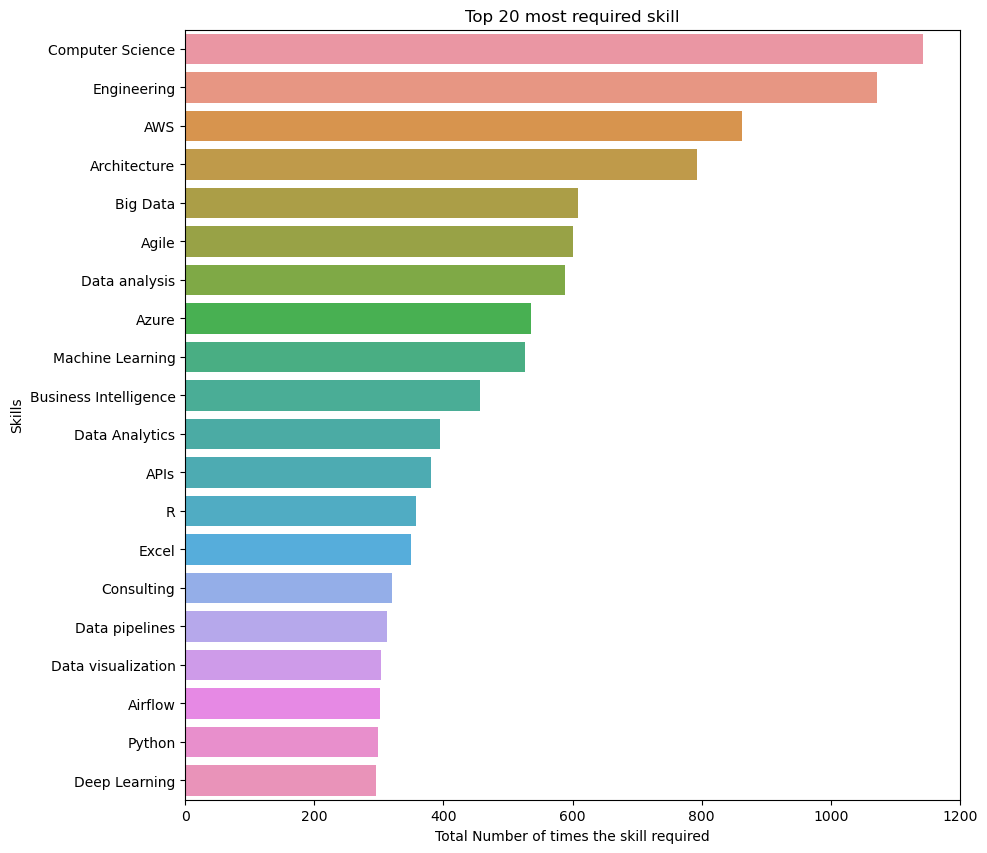

In [46]:
fig, ax = plt.subplots(figsize=(10,10)) 
ax=sns.barplot(data=df_skills.head(20), y='variable' ,x='value').set(title="Top 20 most required skill")
plt.xlabel('Total Number of times the skill required')
plt.ylabel('Skills')

## Checking Interaction of top 20 most required skill with other features

Not excluded Computer Science and Engineering as these 2 is too generic

In [79]:
df_skills_top20=df_skills.head(20).tail(18)

### Interaction between Skill & Experience-level  & Job-Title; Based on Frequency

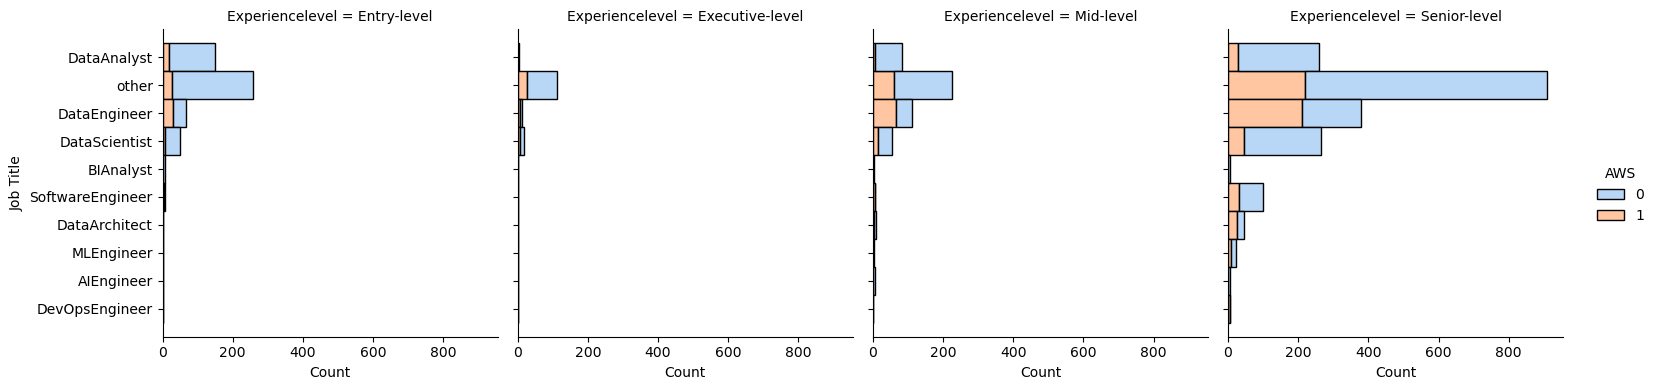

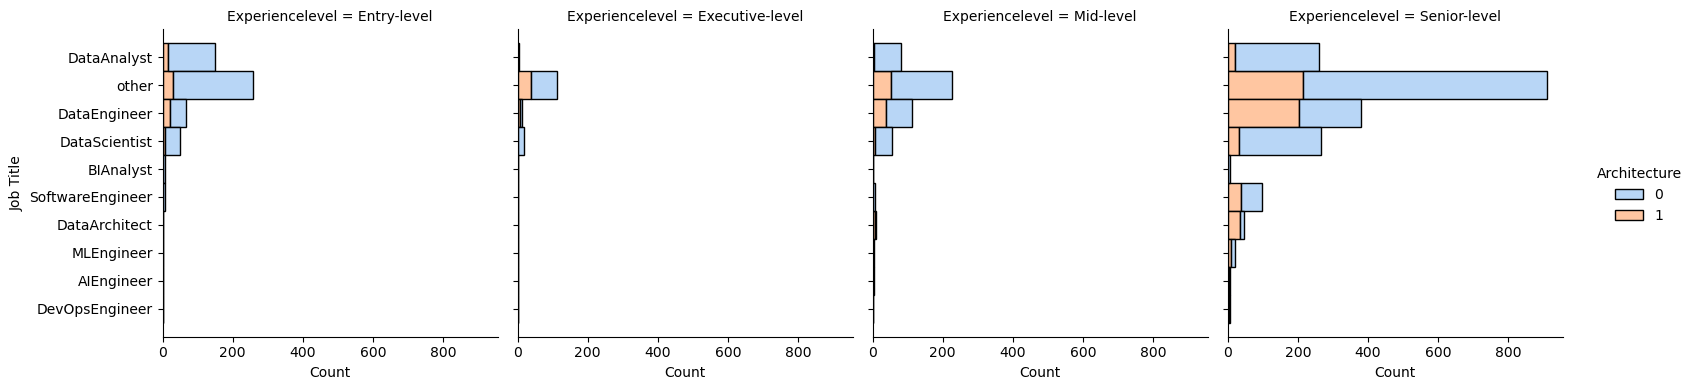

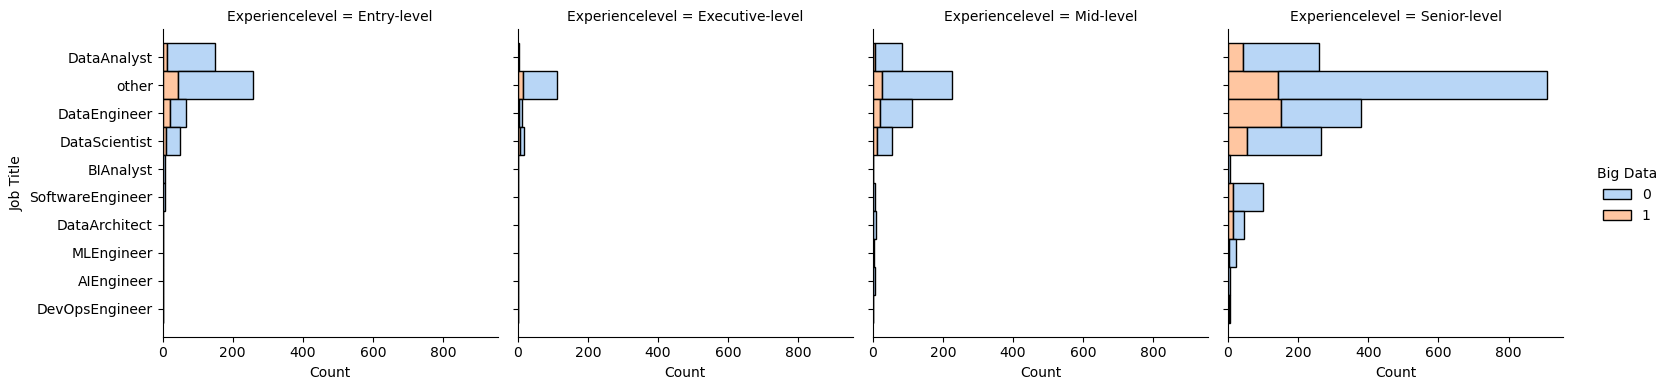

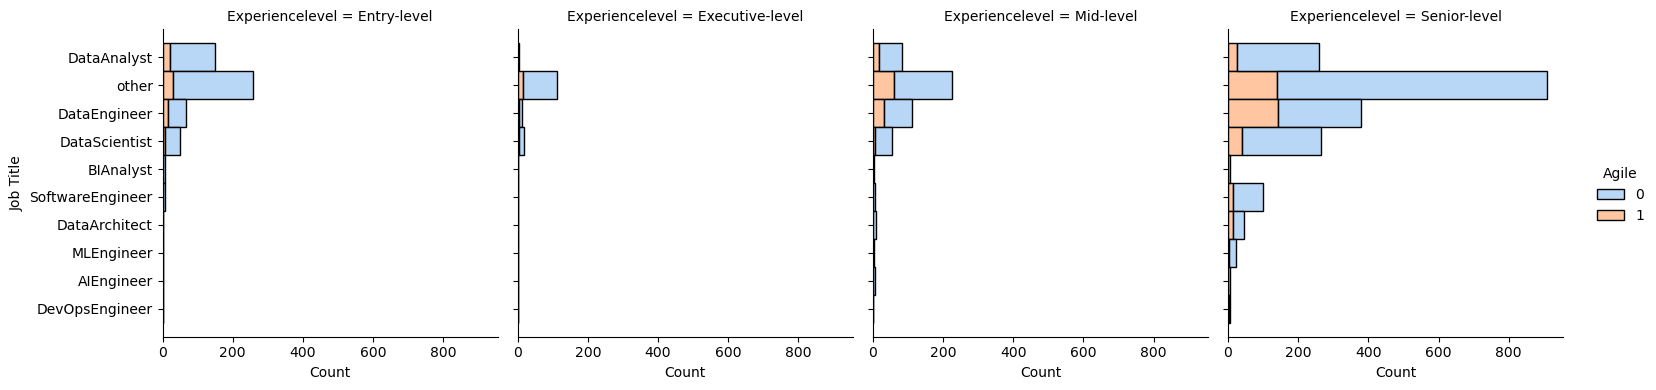

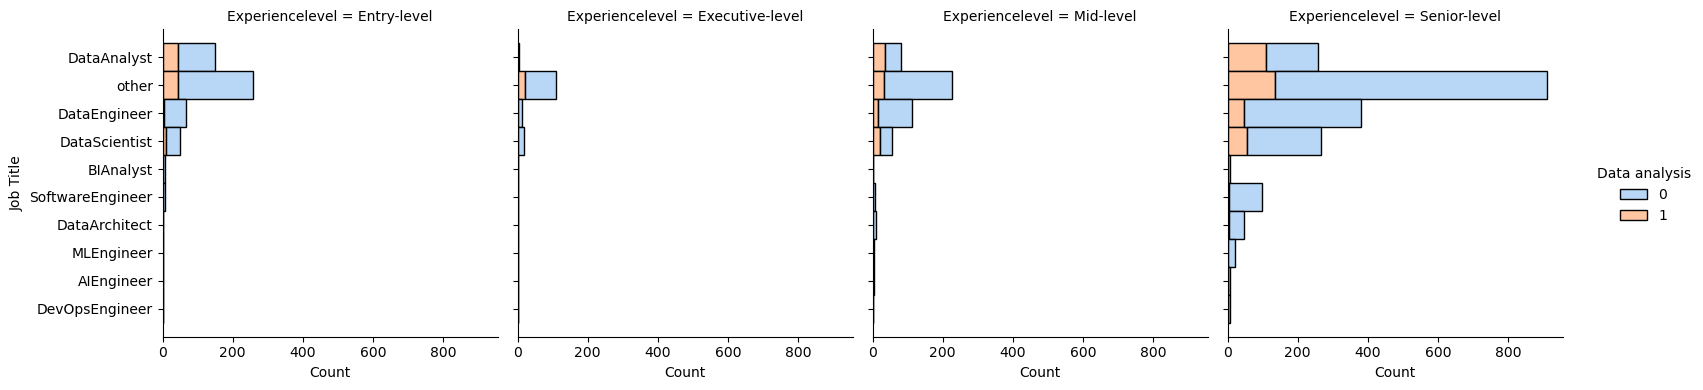

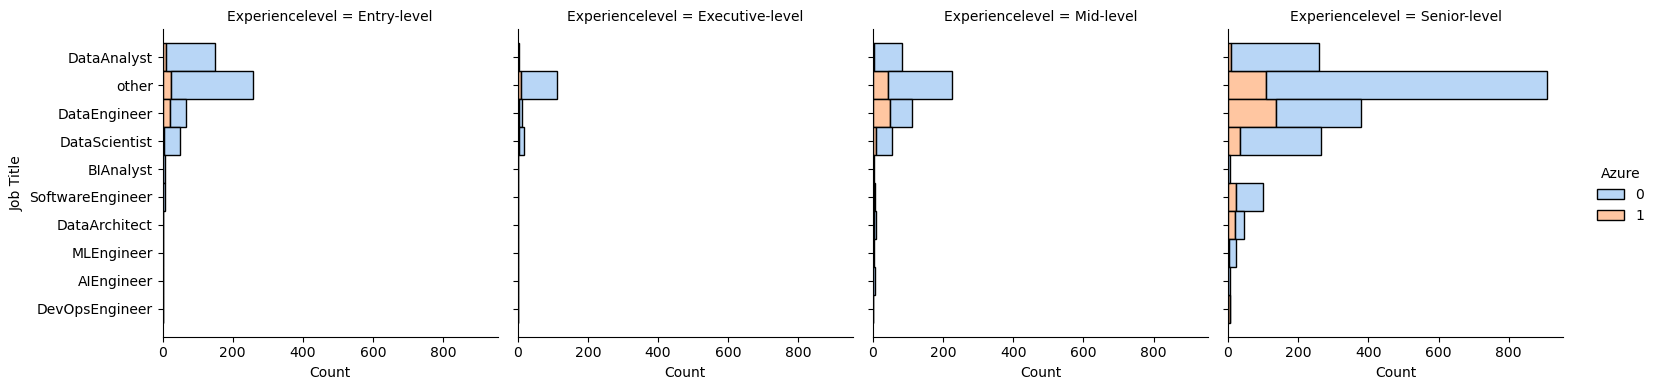

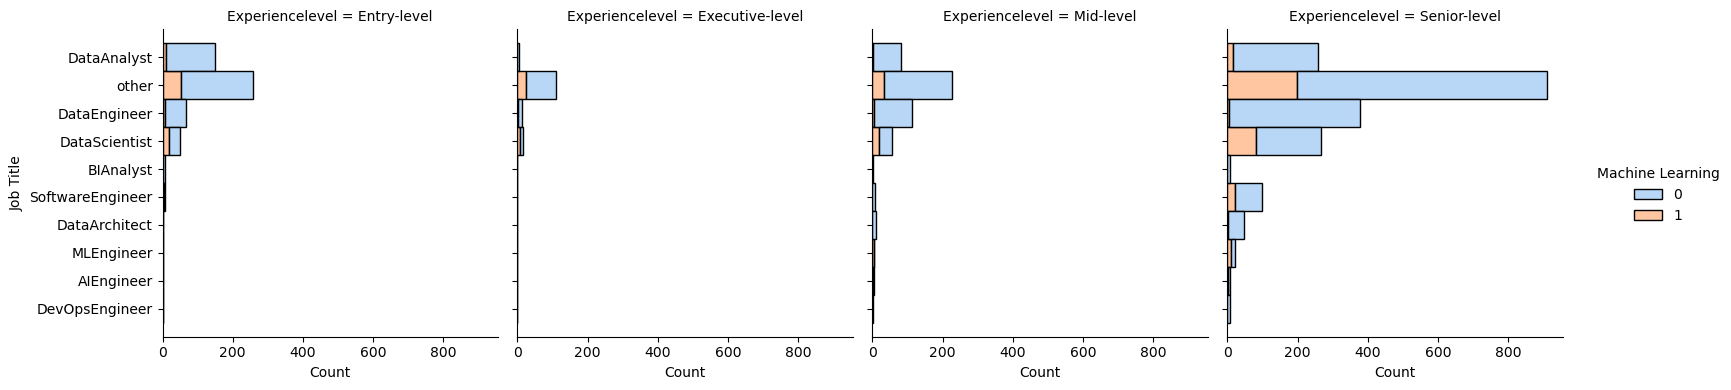

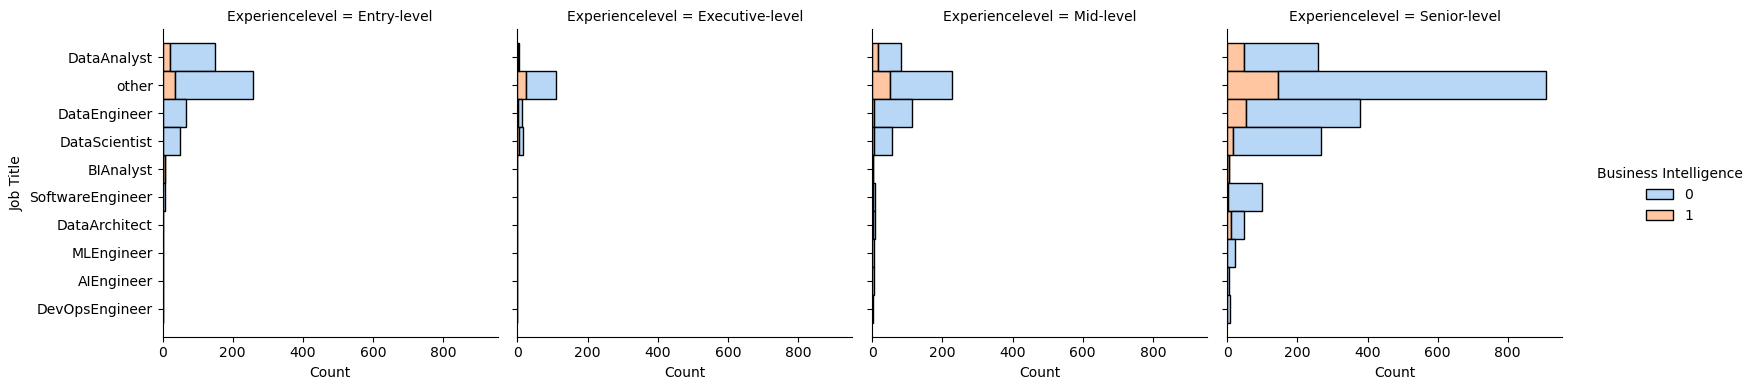

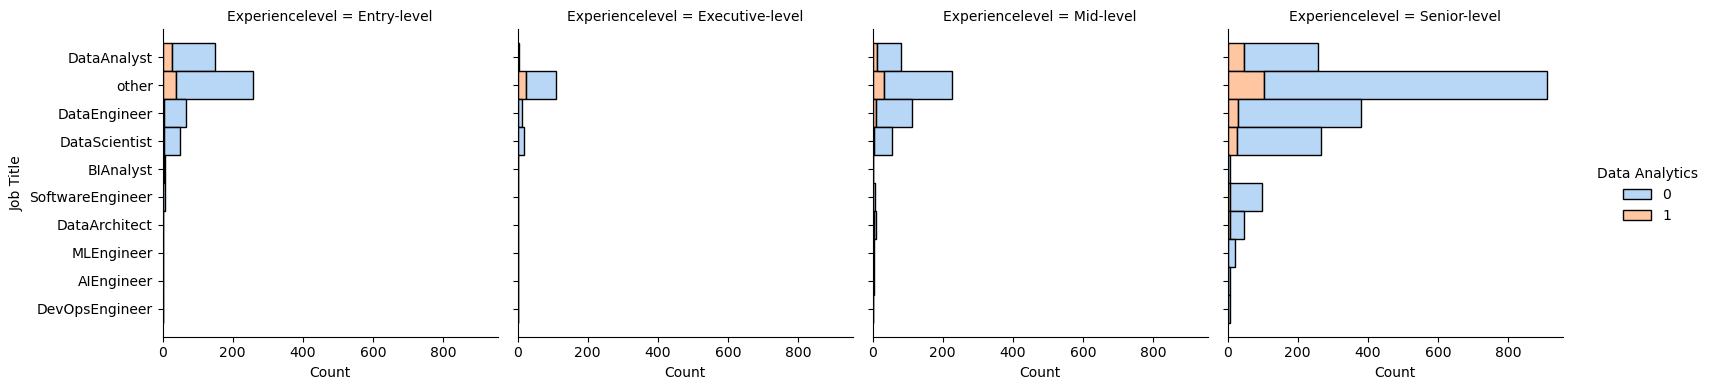

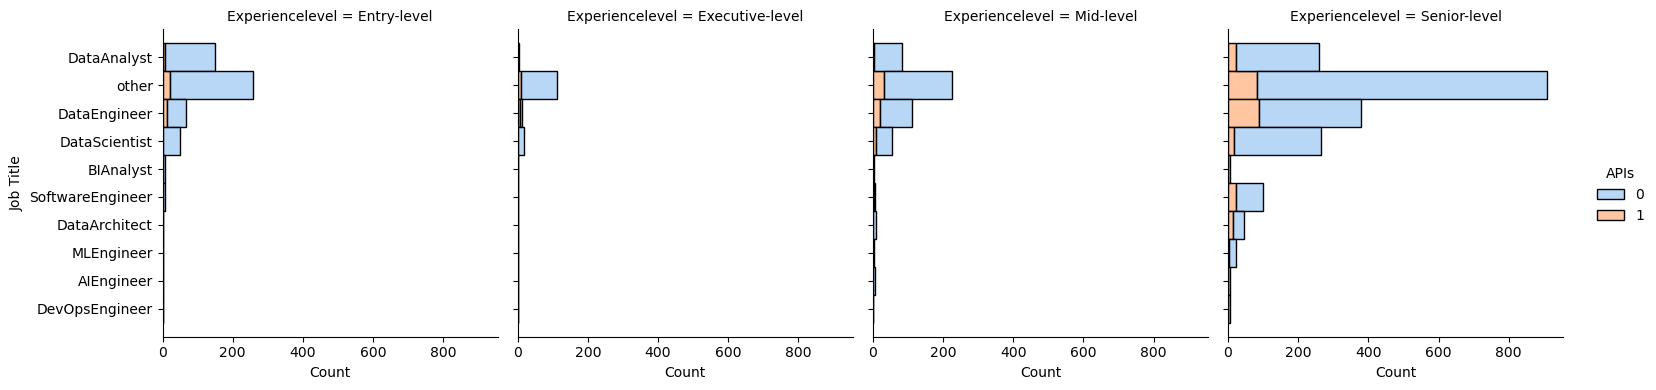

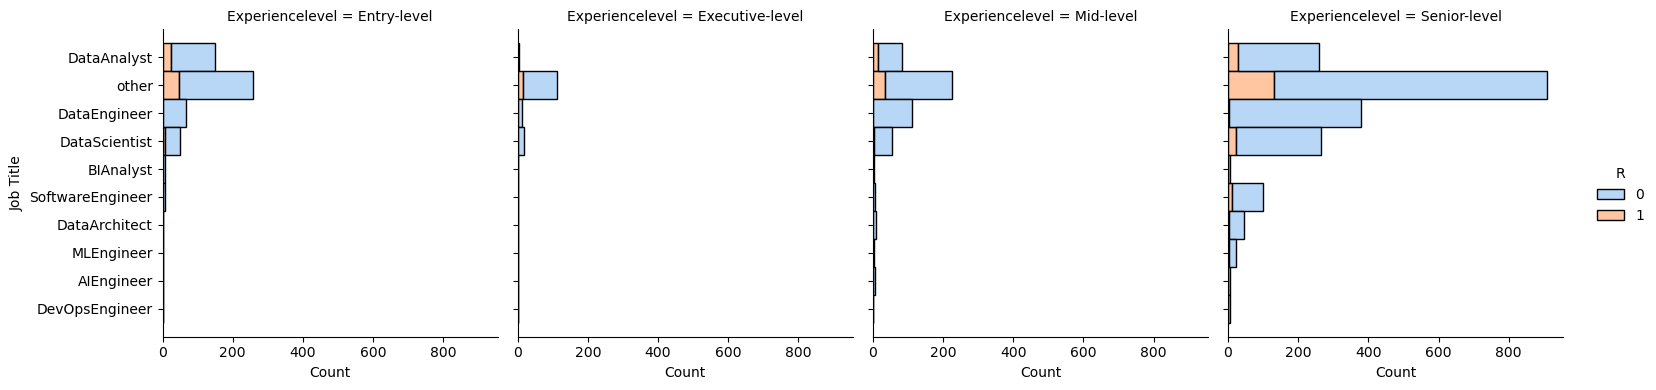

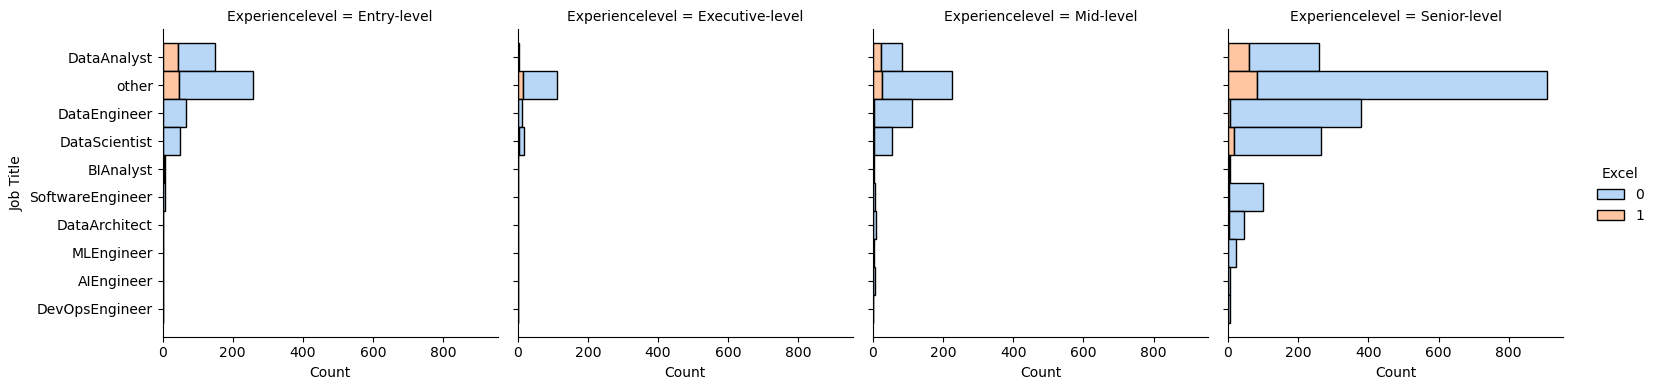

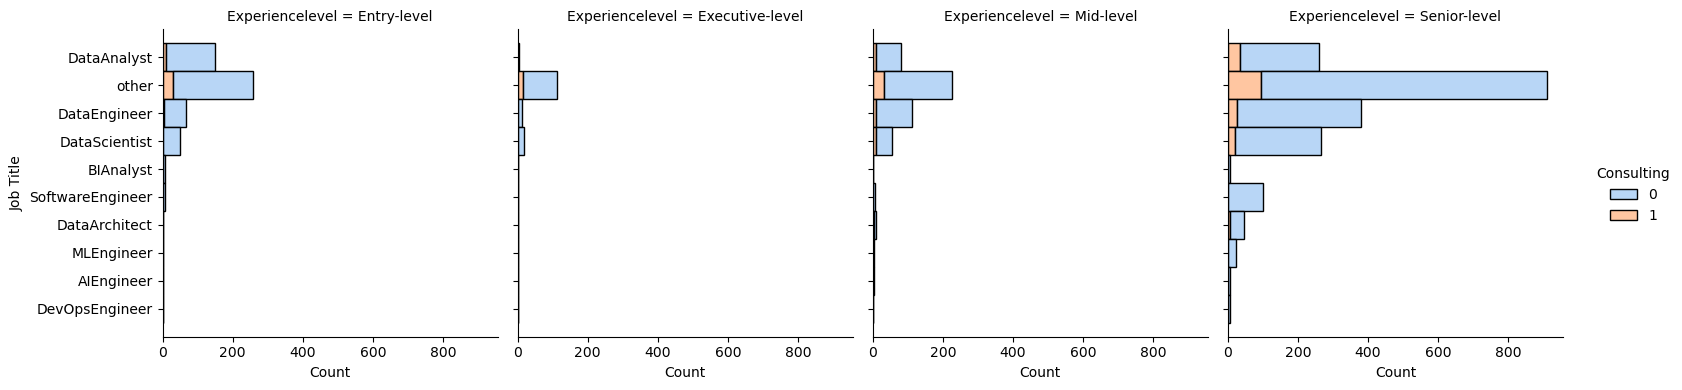

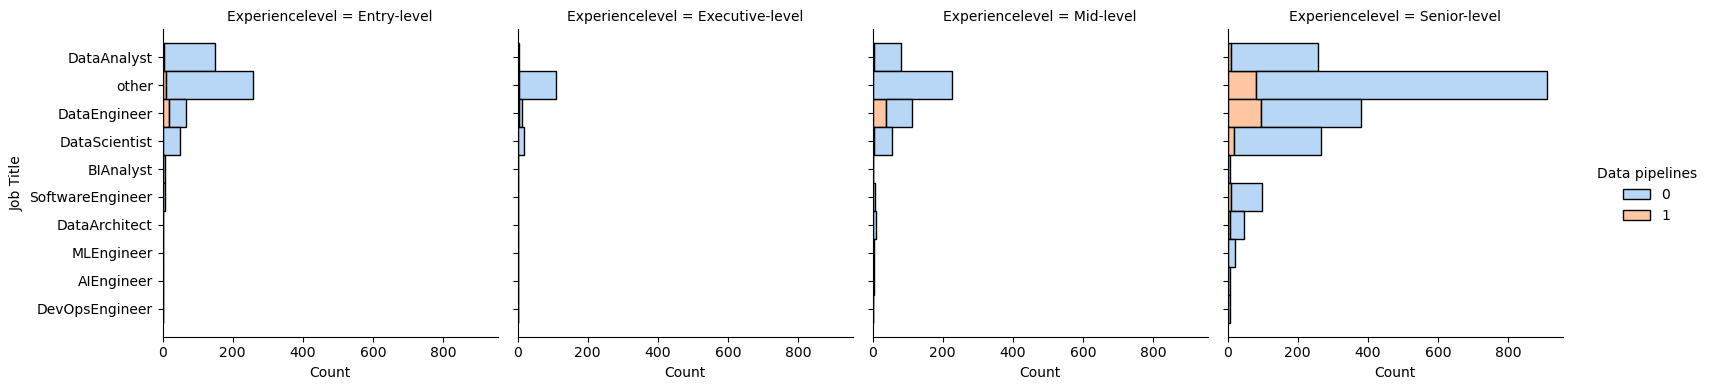

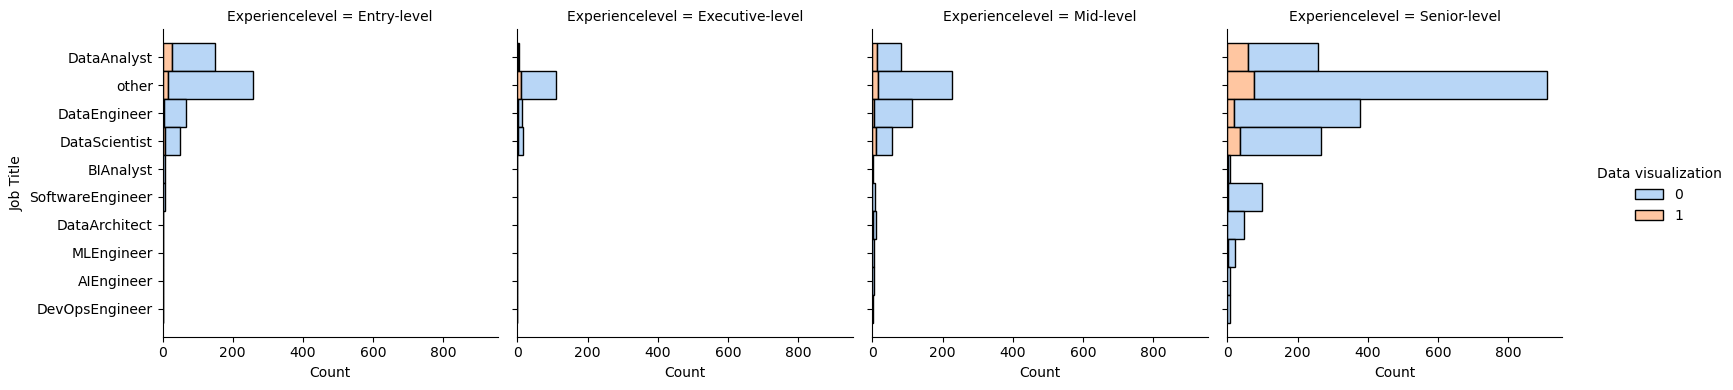

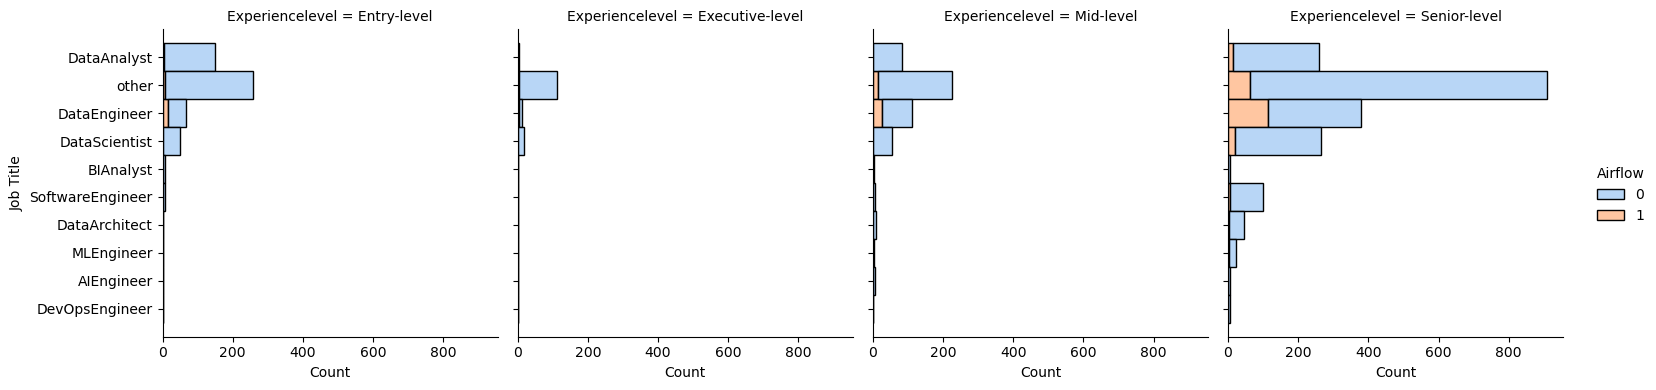

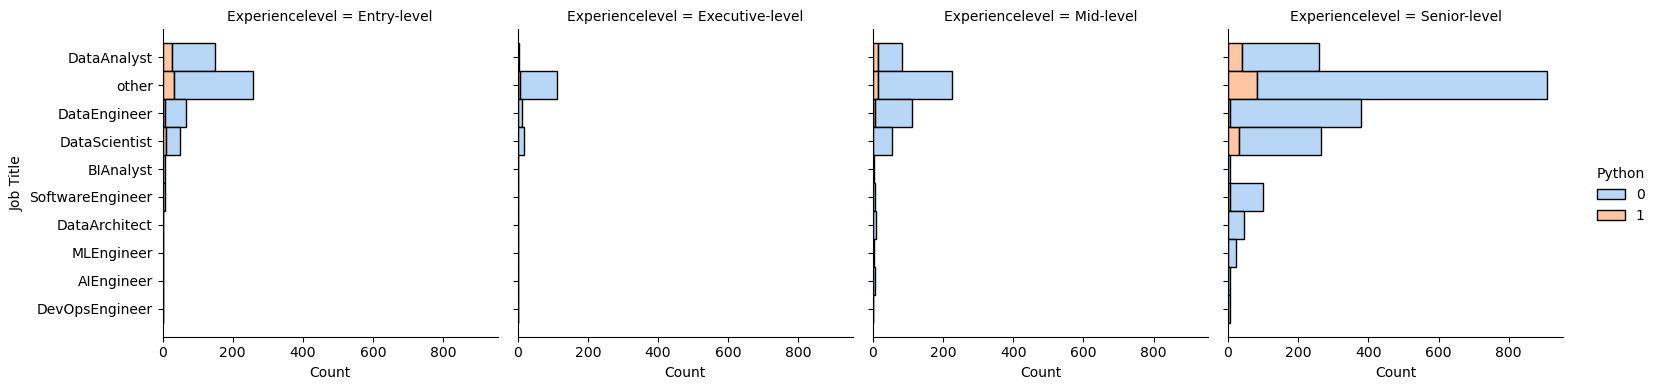

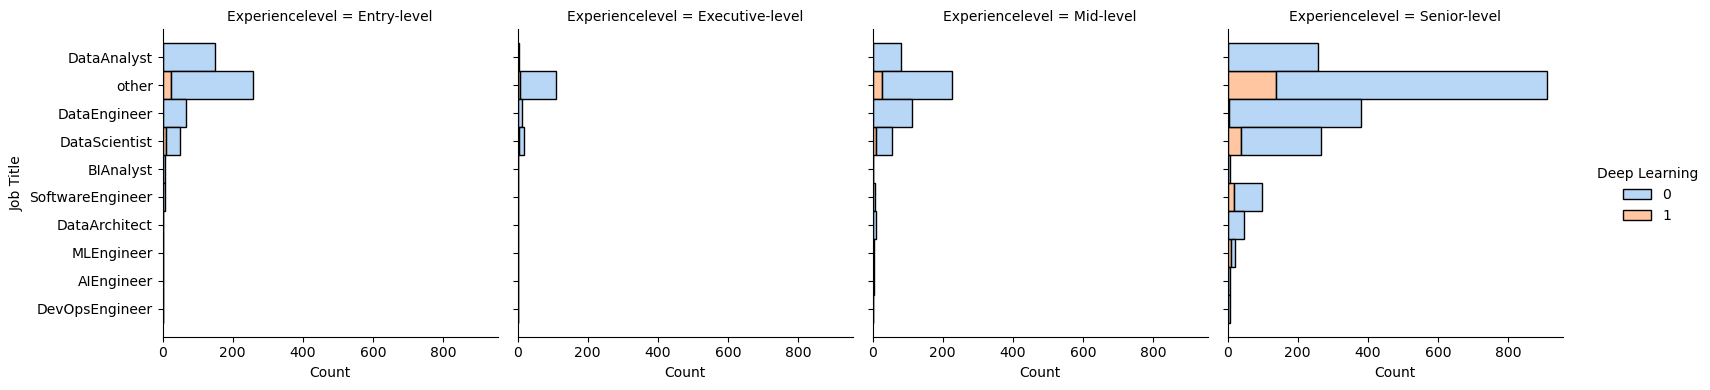

In [99]:
for i in df_skills_top20.variable.unique():
    ax=sns.displot( dfv01 , y = 'JobTitle_Unique', hue=i , palette=sns.color_palette("pastel",2), height=4,
                multiple="stack", col='Experiencelevel' ).set_axis_labels("Count",
                "Job Title" )

### Interaction between Skill & Experience-level  & Job-Title; Based on Salary

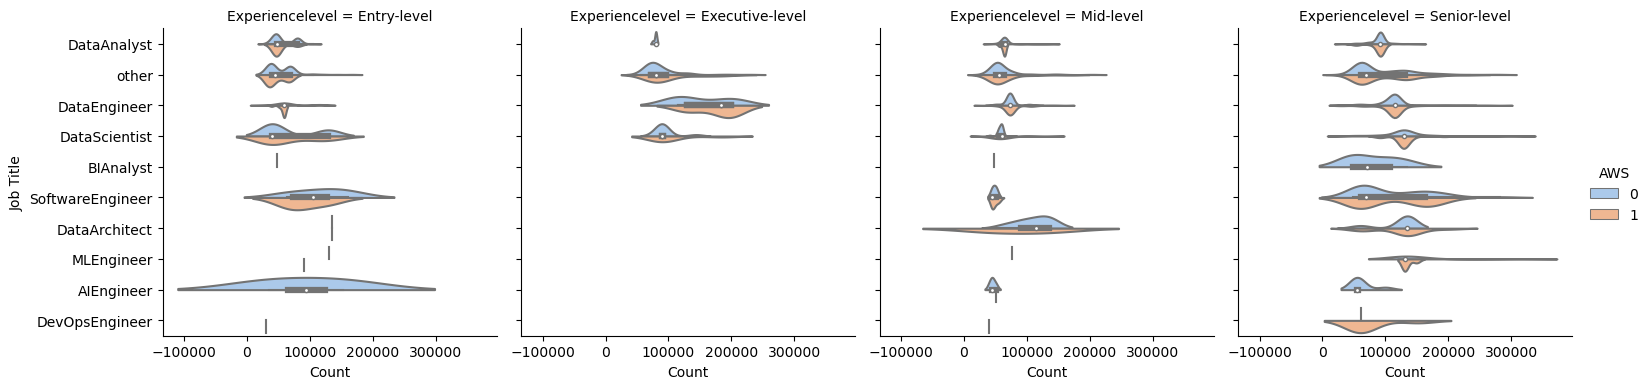

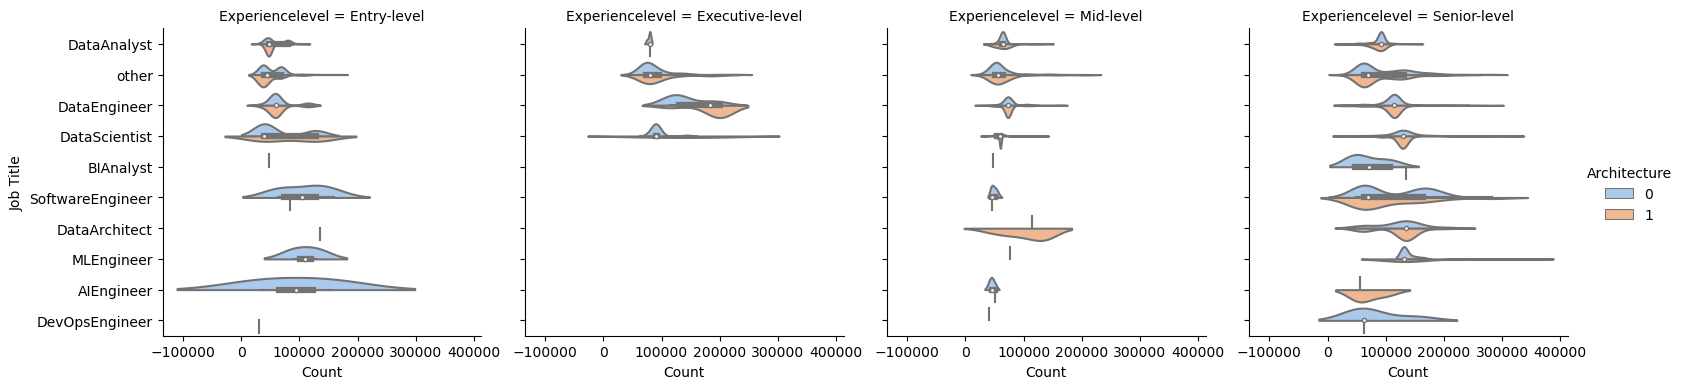

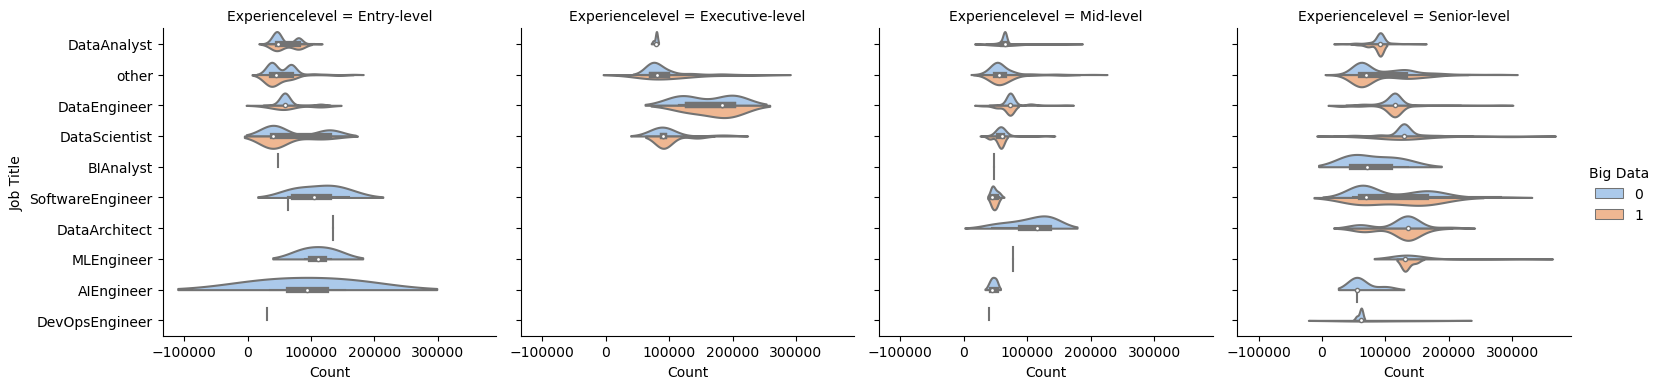

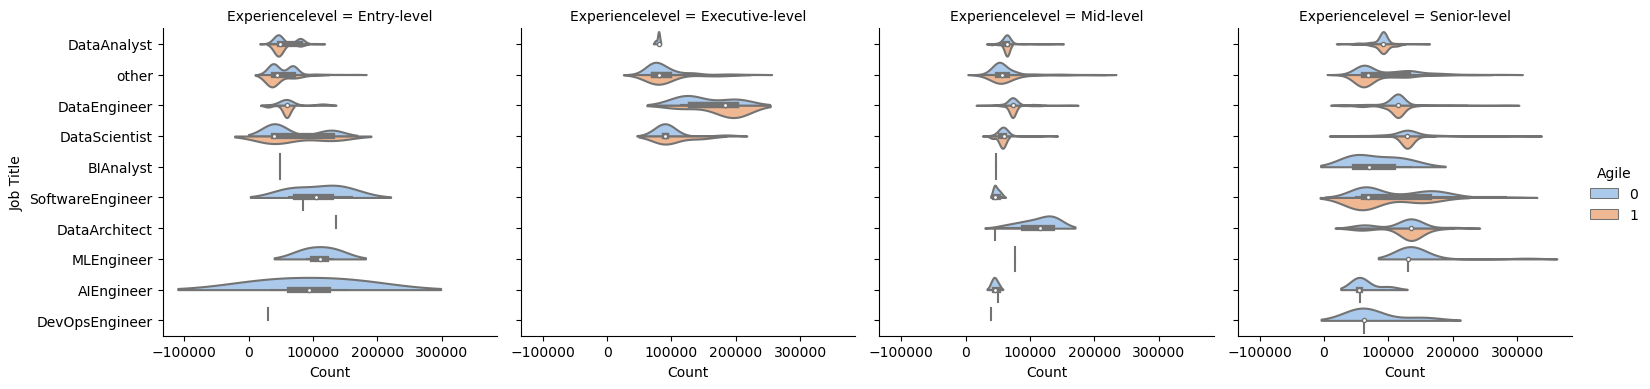

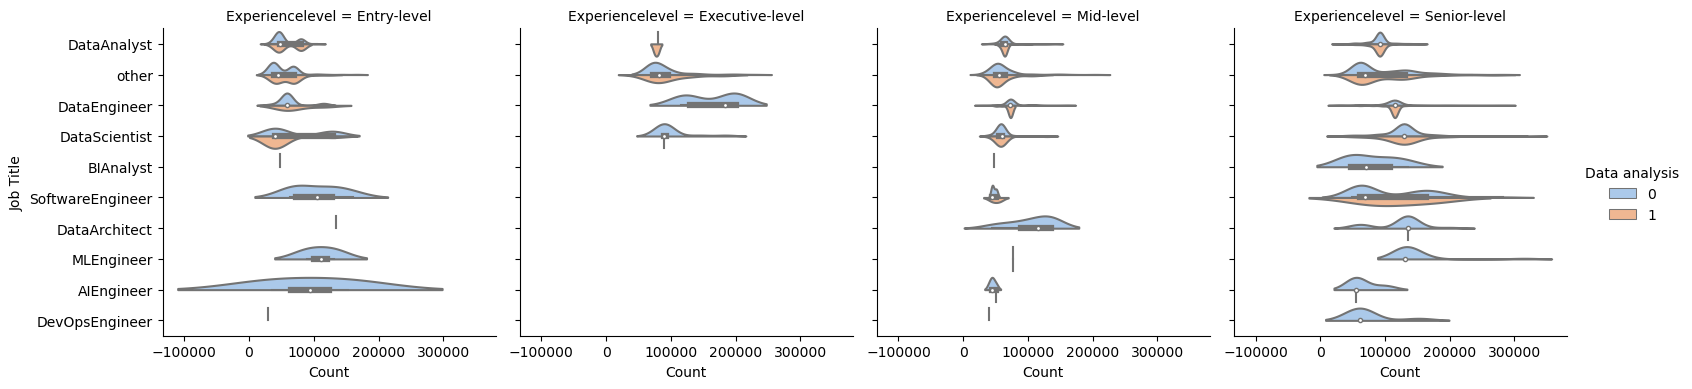

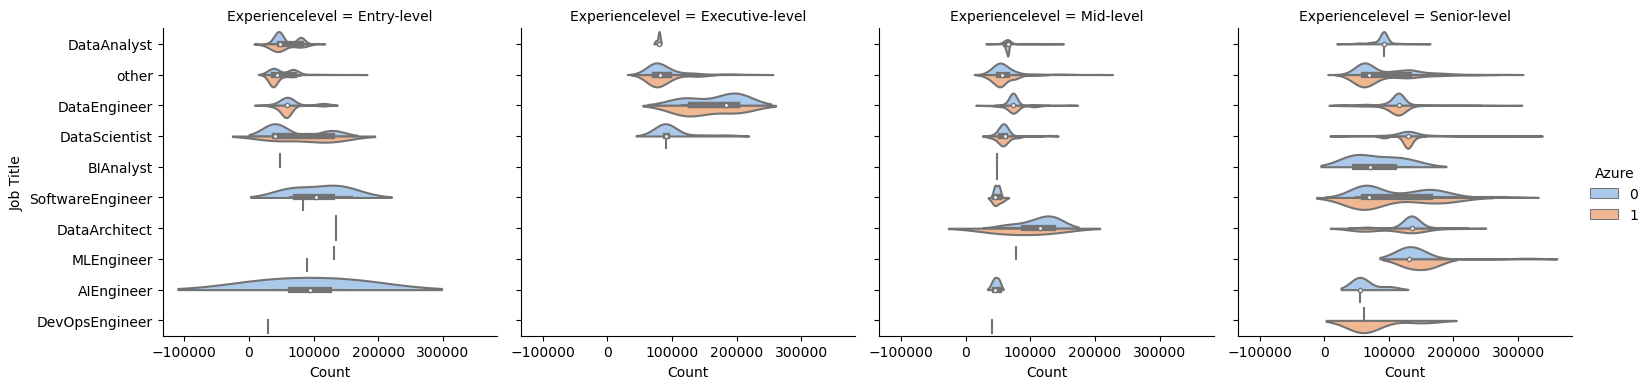

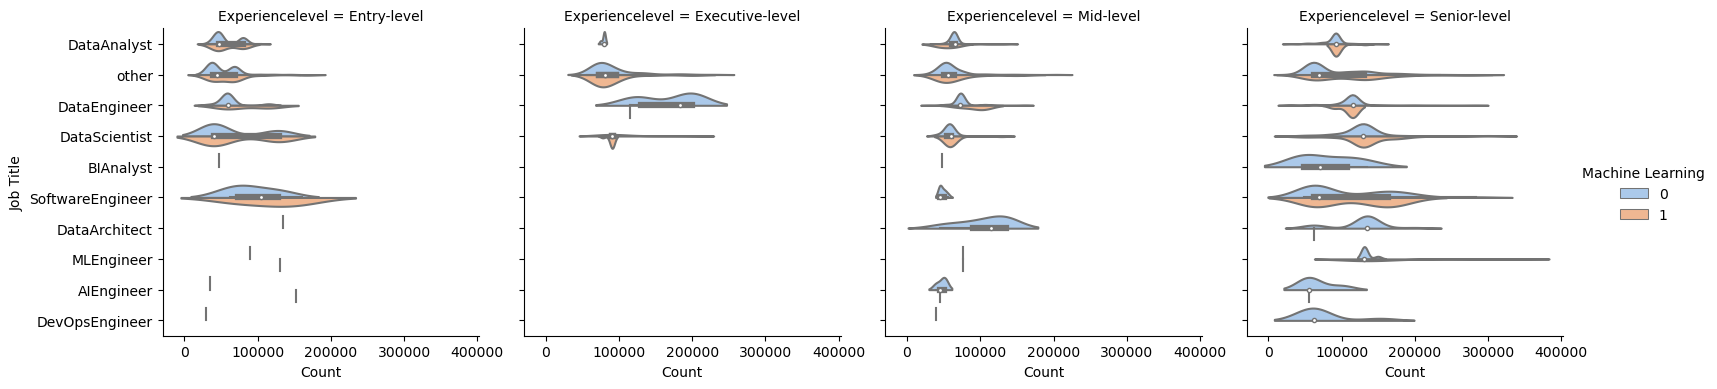

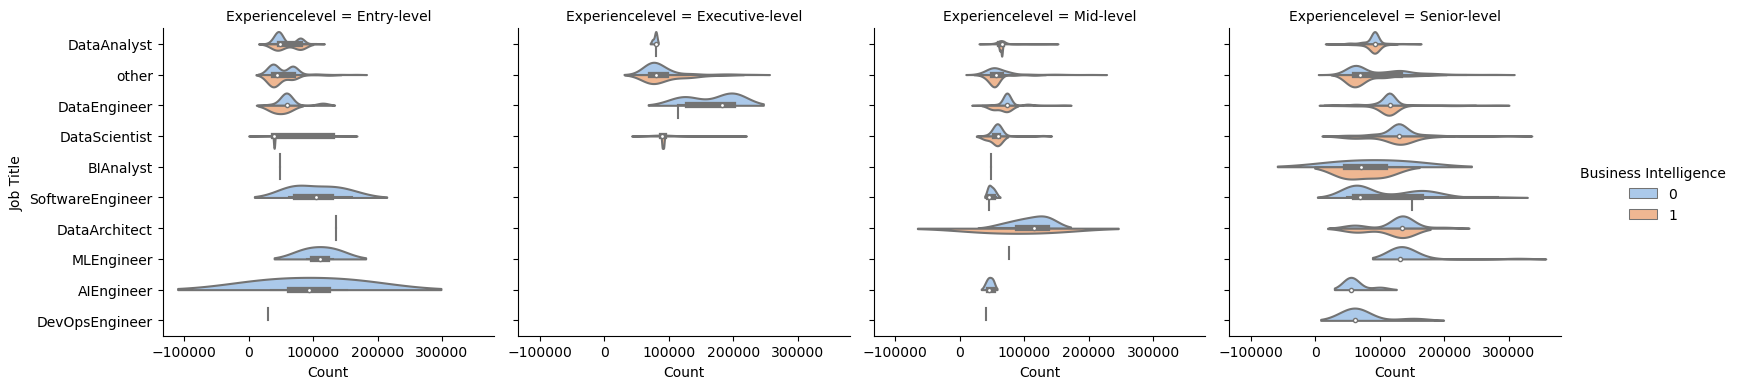

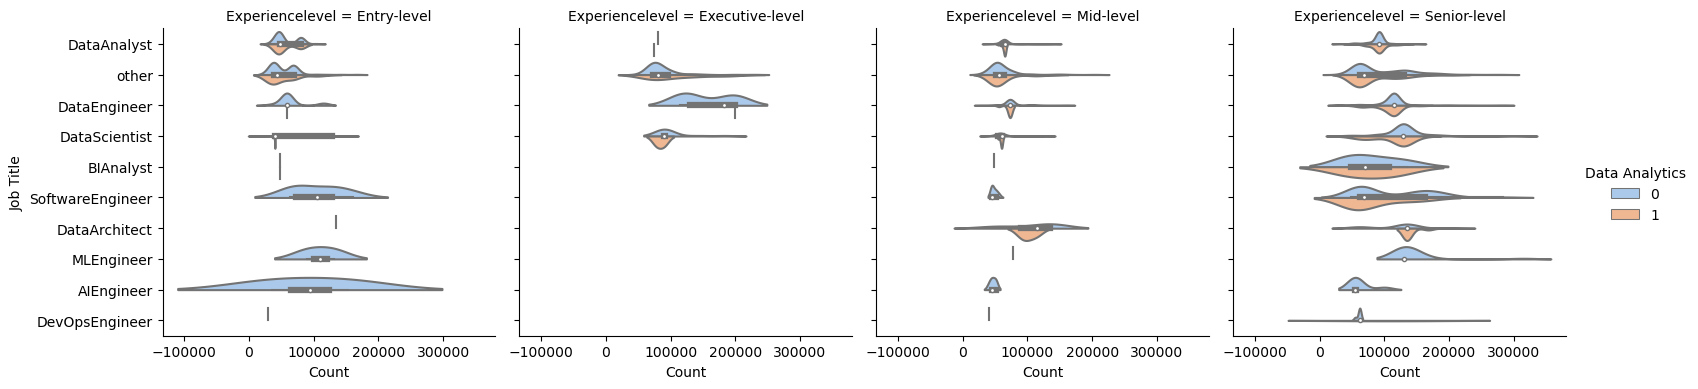

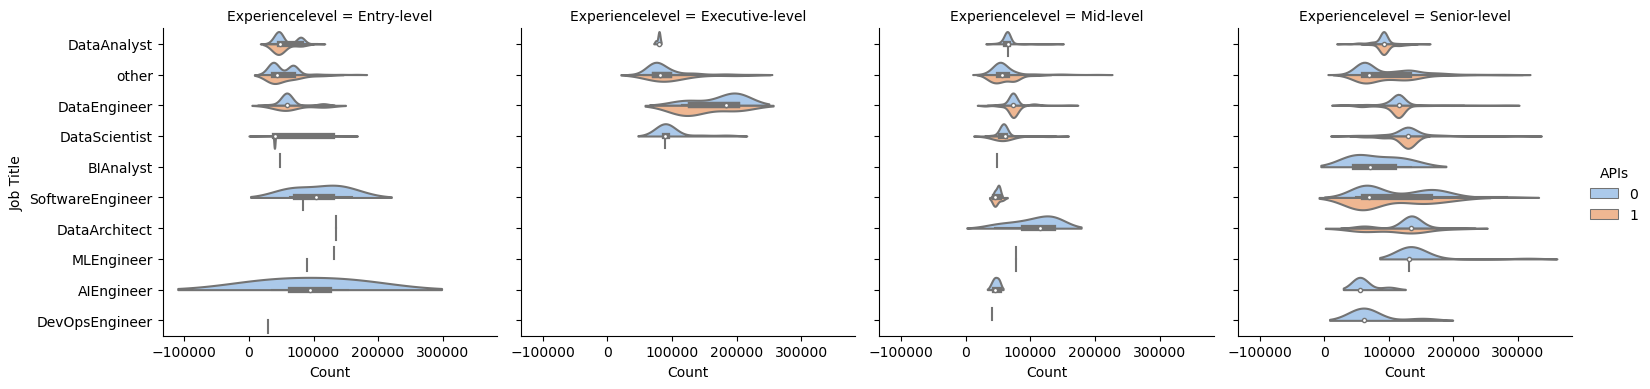

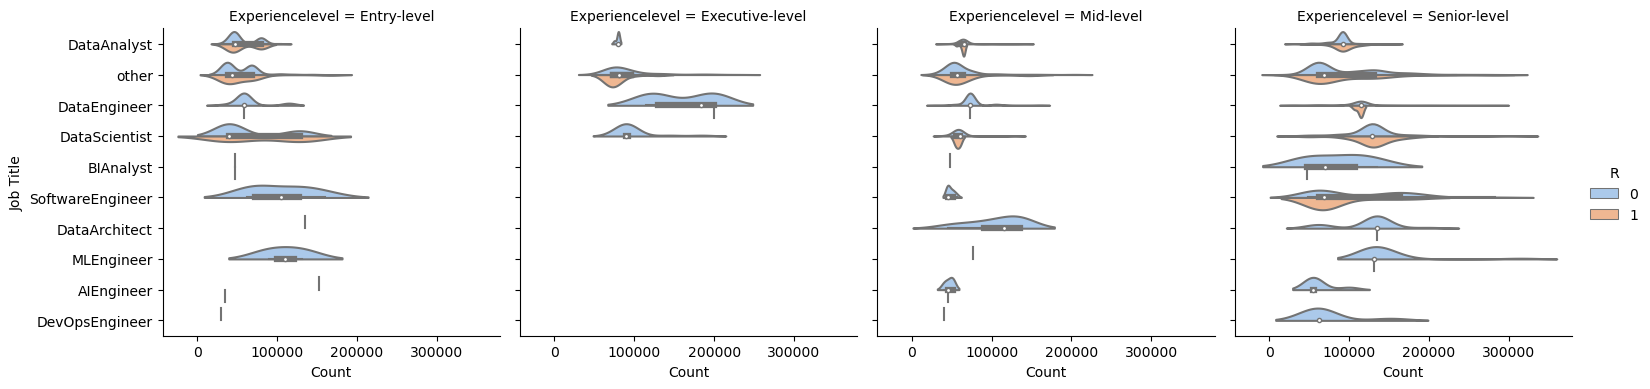

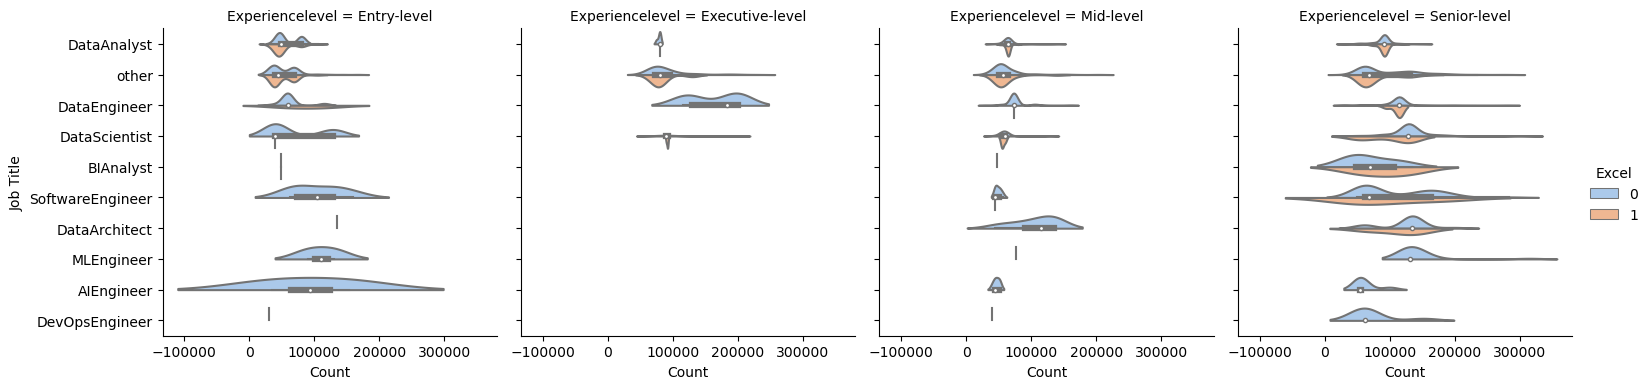

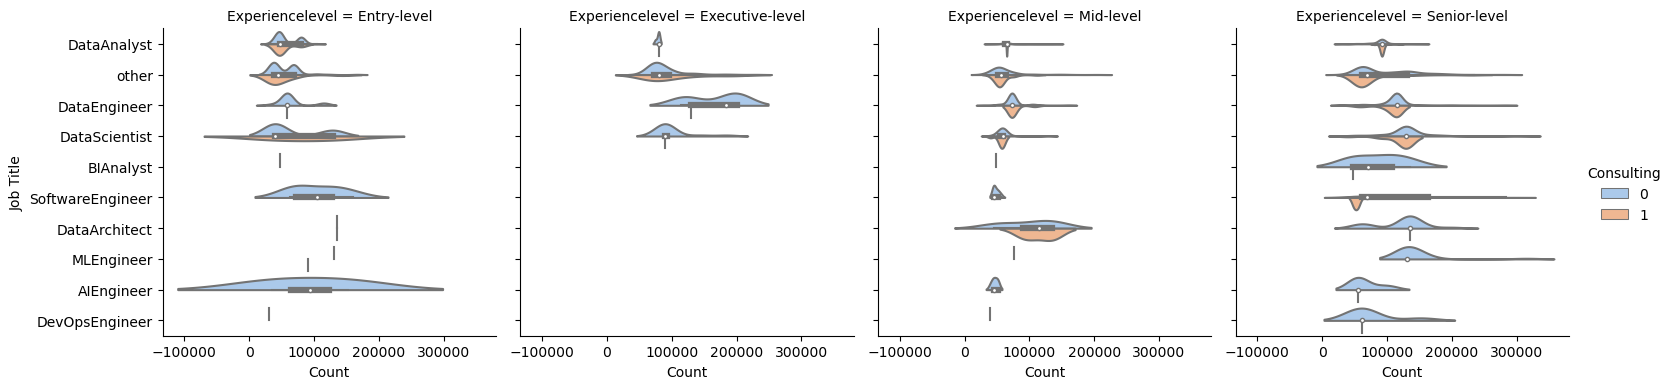

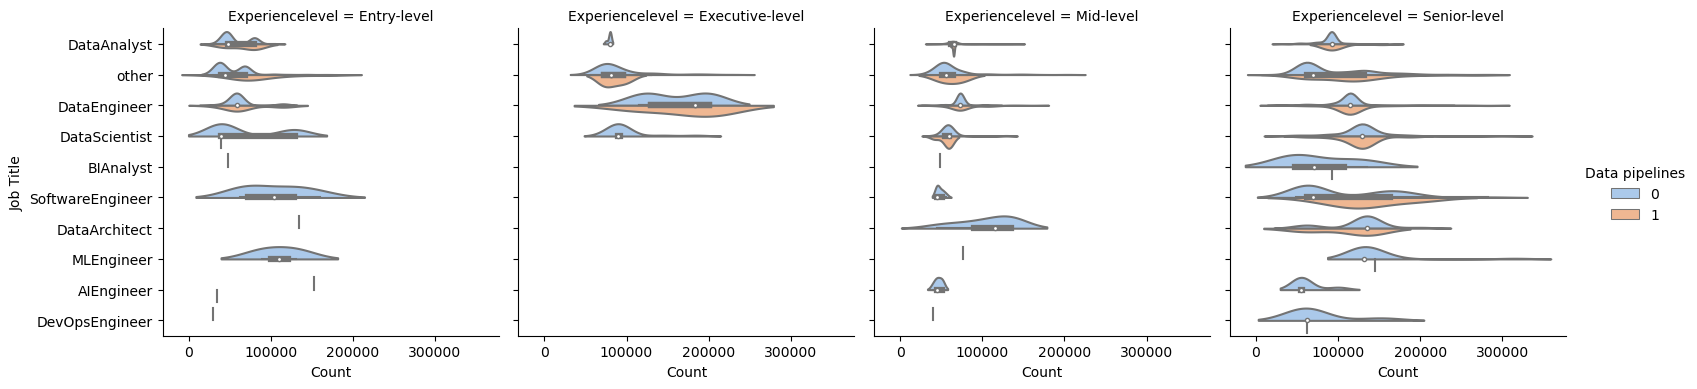

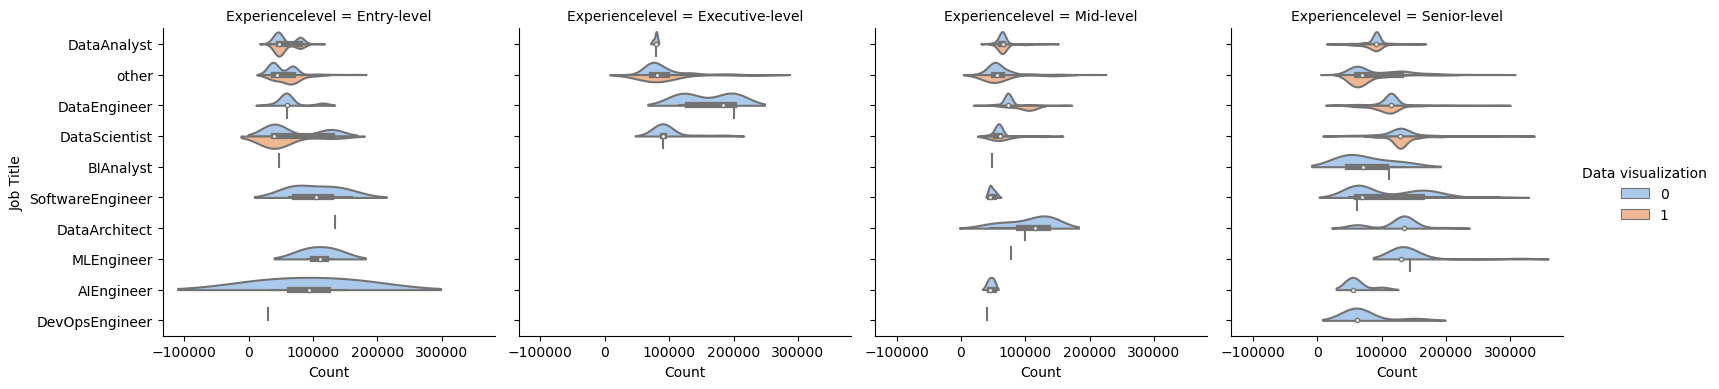

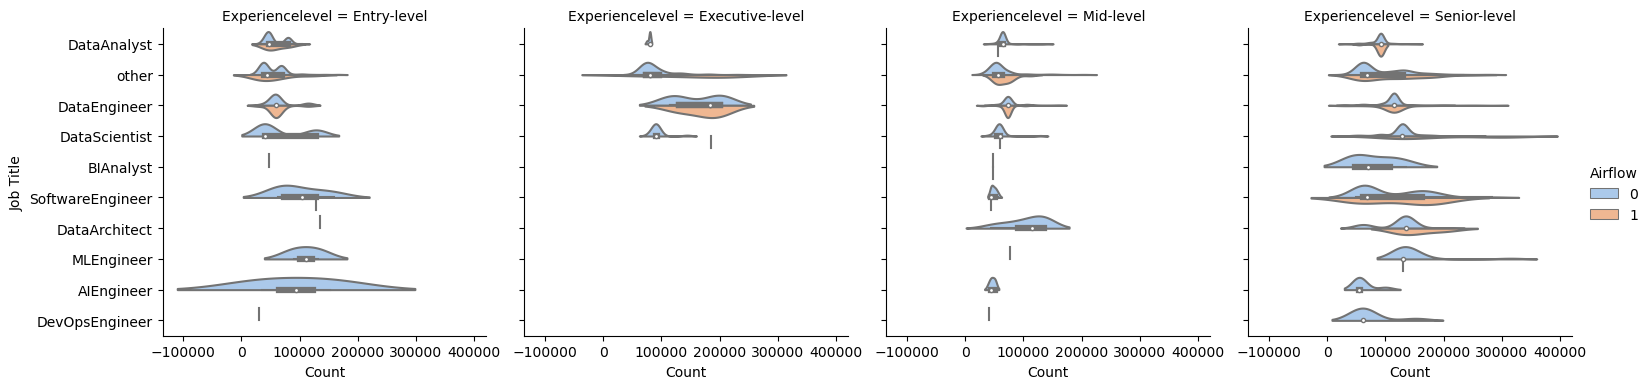

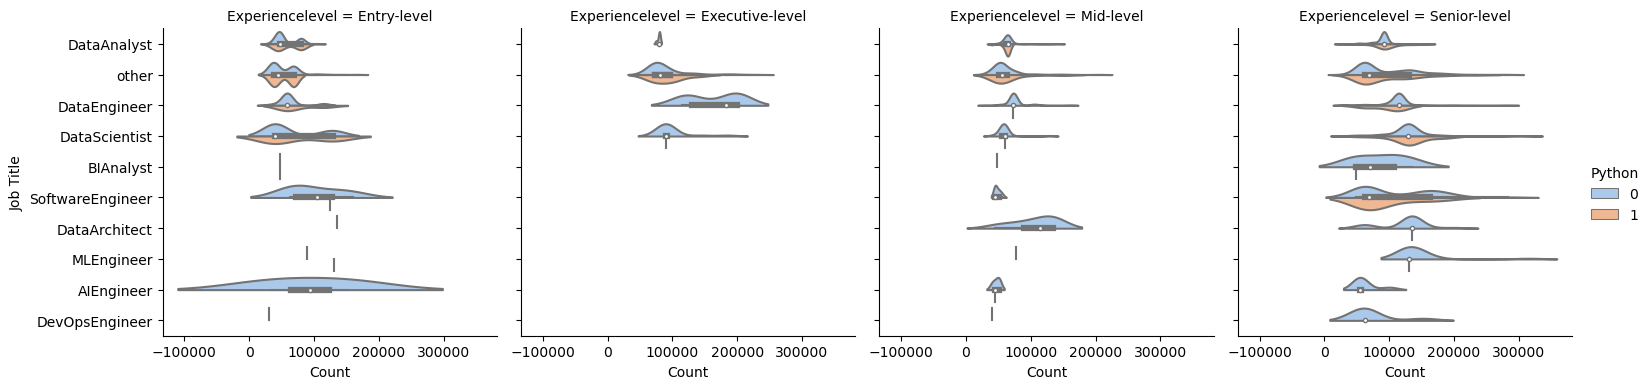

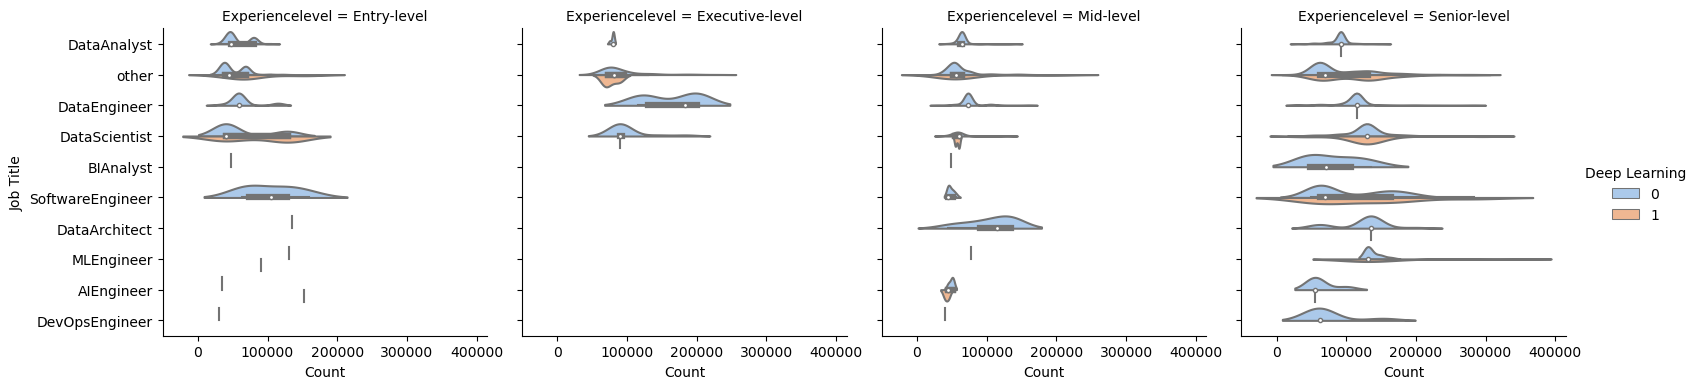

In [106]:
for i in df_skills_top20.variable.unique():
    ax=sns.catplot( dfv01 , x='Salary_num', y = 'JobTitle_Unique',col='Experiencelevel' , 
                   hue=i , kind="violin" , split=True,
                   palette=sns.color_palette("pastel",2), height=4).set_axis_labels("Count", "Job Title" )

## Association rule mining for skills

Lets check which skills are required to be possessed together.

In [51]:
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

### Using the FP-Growth algorithm to generate frequent itemsets with a minimum support equals to 3%  and finding all association rules with a minimum confidence equals to 50%

So now we are looking at most insightful associations. For all skill groups listed above, skills in them appeared minimum  3% of time together in job ads. Also for all skills in antecedents group minimum 50% of time followed by skill in consequents.  

In [52]:
frequent_itemsets=fpgrowth(dfv01[requirements_list], min_support=0.03, use_colnames=True)
rules= association_rules(frequent_itemsets,metric="lift", min_threshold=1 ).round(decimals =3)
rules=rules[(rules['confidence']>=0.5)]
rules.sort_values(by=['support'], ascending=False)

/home/pkeskin/anaconda3/envs/COMP47750/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
34,(Azure),(AWS),0.167,0.270,0.110,0.656,2.434,0.065,2.124
78,(Machine Learning),(Engineering),0.164,0.335,0.087,0.530,1.584,0.032,1.416
121,(Airflow),(AWS),0.094,0.270,0.054,0.575,2.132,0.029,1.718
25,(Deep Learning),(Computer Science),0.092,0.357,0.052,0.559,1.565,0.019,1.458
129,(Research),(R),0.050,0.112,0.050,1.000,8.933,0.044,inf
63,"(Azure, Architecture)",(AWS),0.068,0.270,0.045,0.659,2.445,0.026,2.142
45,"(Azure, Computer Science)",(AWS),0.063,0.270,0.044,0.700,2.597,0.027,2.435
80,"(Machine Learning, Computer Science)",(Engineering),0.064,0.335,0.038,0.593,1.771,0.016,1.635
10,"(Agile, AWS)",(Architecture),0.072,0.248,0.037,0.515,2.080,0.019,1.552
50,"(Azure, Agile)",(AWS),0.058,0.270,0.032,0.560,2.077,0.017,1.659


#### Example interpretation: 
If the requirement of company contains Deep Learning there is 55.9 % probability of seeing Computer science in requirement. 5.2% of ads contains items in rule 10 together. 

### Notable Skill Association Rules
* If Azure skill is required there is  65.6% chance AWS skill is also required and  11% of time rule appear. 
* All ads require one to have research skill also required one to have R skill.
* If Databricks skill is required there there is  50.8.5% chance Azure skill is also required but 3% of time rule appear.

In [53]:
rules_prime=rules.reset_index()
rules_prime["antecedents"] = rules_prime["antecedents"].astype("unicode")
rules_prime["consequents"] = rules_prime["consequents"].astype("unicode")
rules_prime['imp_assosication']=rules_prime['antecedents']+'-->'+rules_prime['consequents']
rules_prime=rules_prime.sort_values(by=['support'], ascending=False).drop_duplicates(subset=['imp_assosication'], 
                                                                                     keep="first")

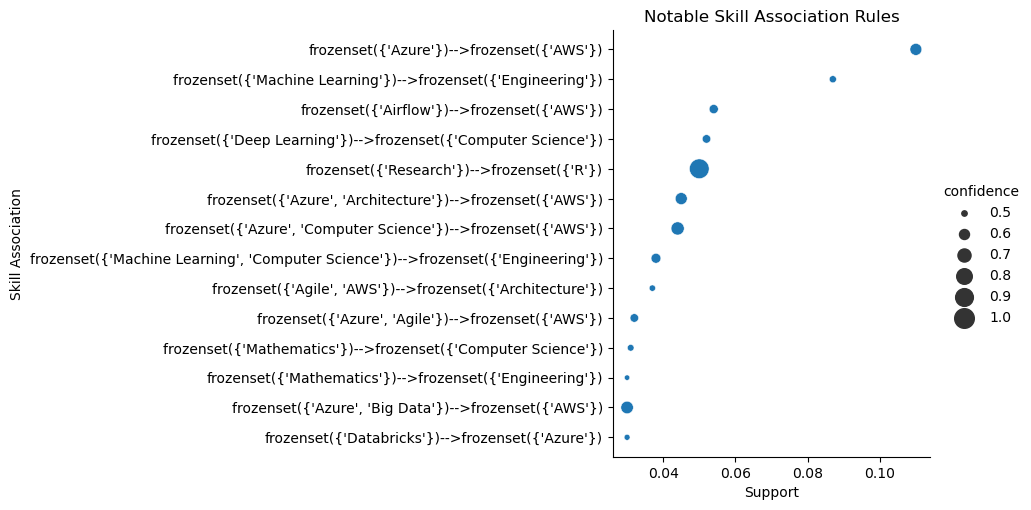

In [54]:
sns.relplot(rules_prime[['support','confidence','imp_assosication']], 
            x= 'support', aspect=2, size='confidence', y='imp_assosication' ,
            sizes=(15, 200)).set_axis_labels("Support" ,"Skill Association").set(title="Notable Skill Association Rules")

# Country based observations

Text(0.5, 1.0, 'Top 20 country with most # of job ads')

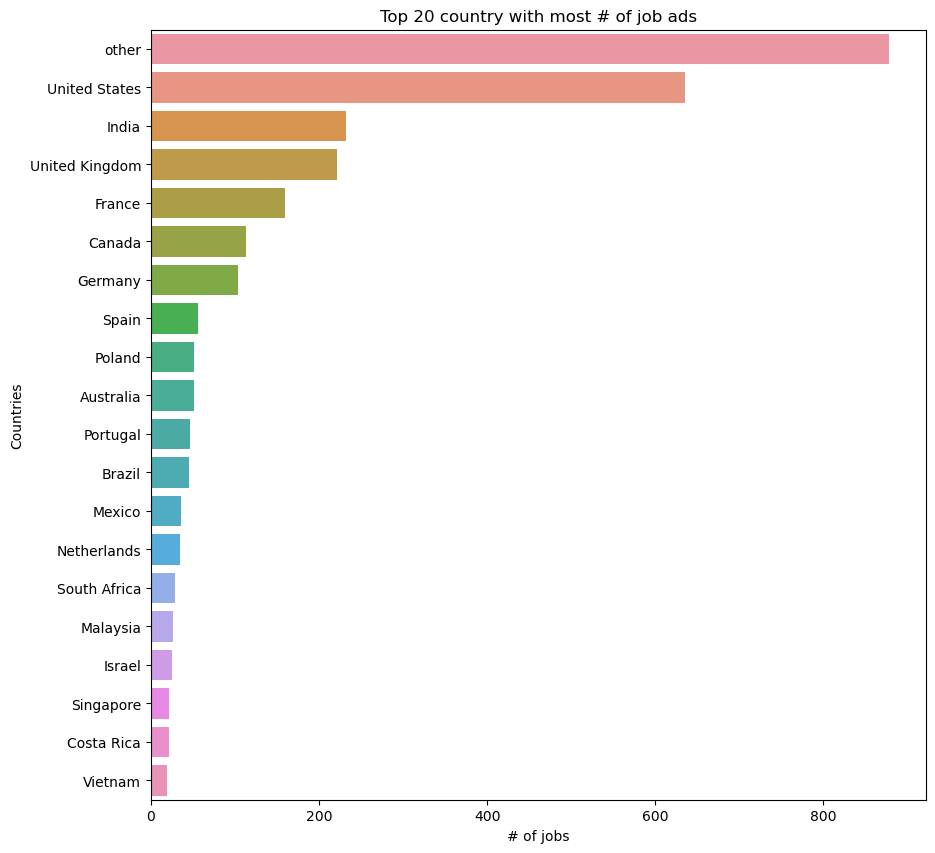

In [55]:
df_country=dfv01['Countries'].value_counts().reset_index().head(20)
fig, ax = plt.subplots(figsize=(10,10)) 
ax=sns.barplot(data=df_country, y='index' ,x='Countries')
plt.xlabel('# of jobs')
plt.ylabel('Countries')
plt.title('Top 20 country with most # of job ads')

Text(0.5, 0.98, 'Top 20 country with most # of job ads; Experience breakdown')

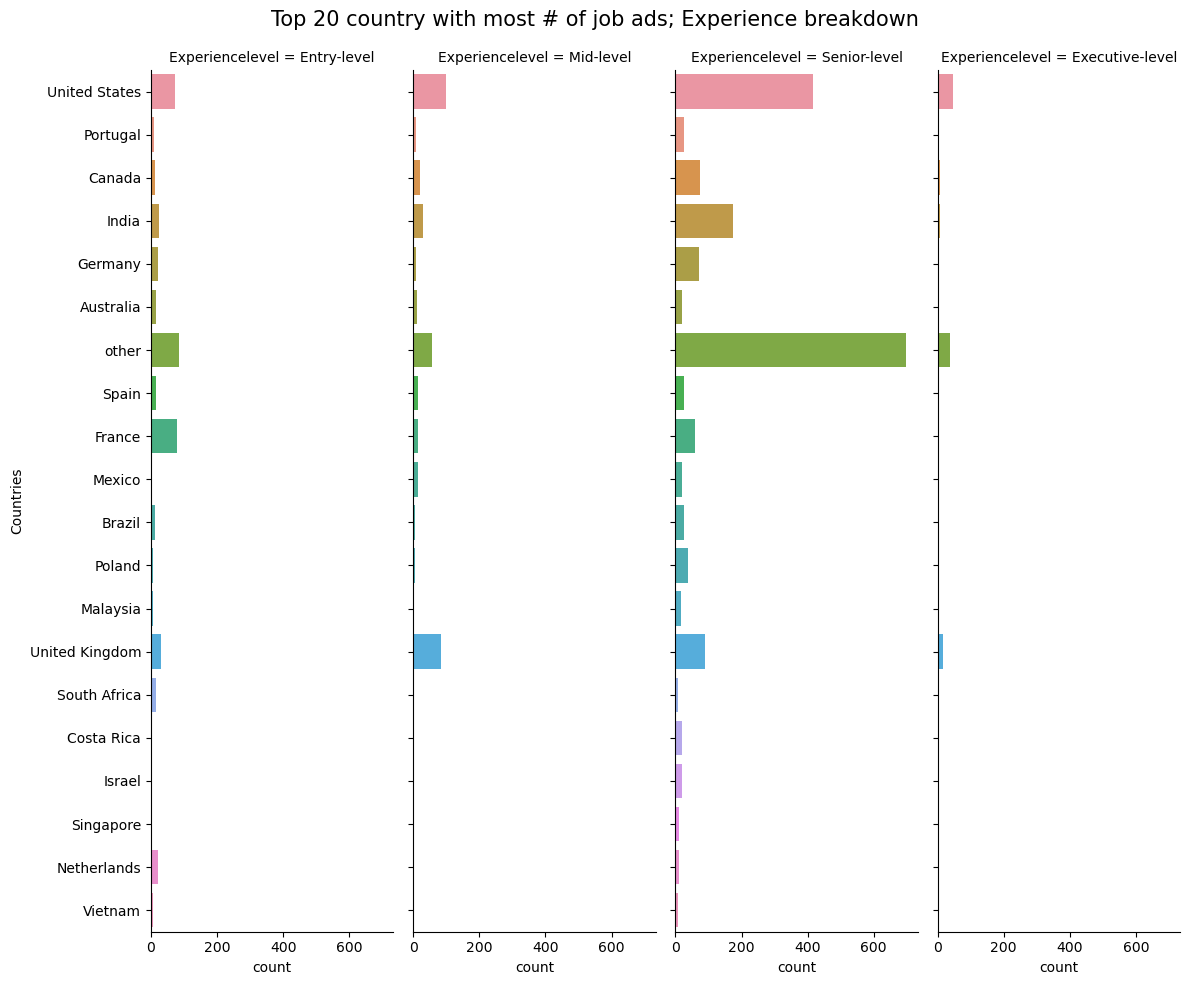

In [58]:
g=sns.catplot(data=dfv01.loc[dfv01.Countries.isin(df_country['index'])], height=10, aspect=0.3,
              y='Countries' ,kind="count",col= 'Experiencelevel')
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Top 20 country with most # of job ads; Experience breakdown', size=15)

In [59]:
df_country_salary=dfv01.groupby('Countries')['Salary_num'].mean().reset_index().sort_values(by=['Salary_num'], 
                                                                                            ascending=False).head(20)

Text(0.5, 1.0, 'Top 20 country by highest mean salary')

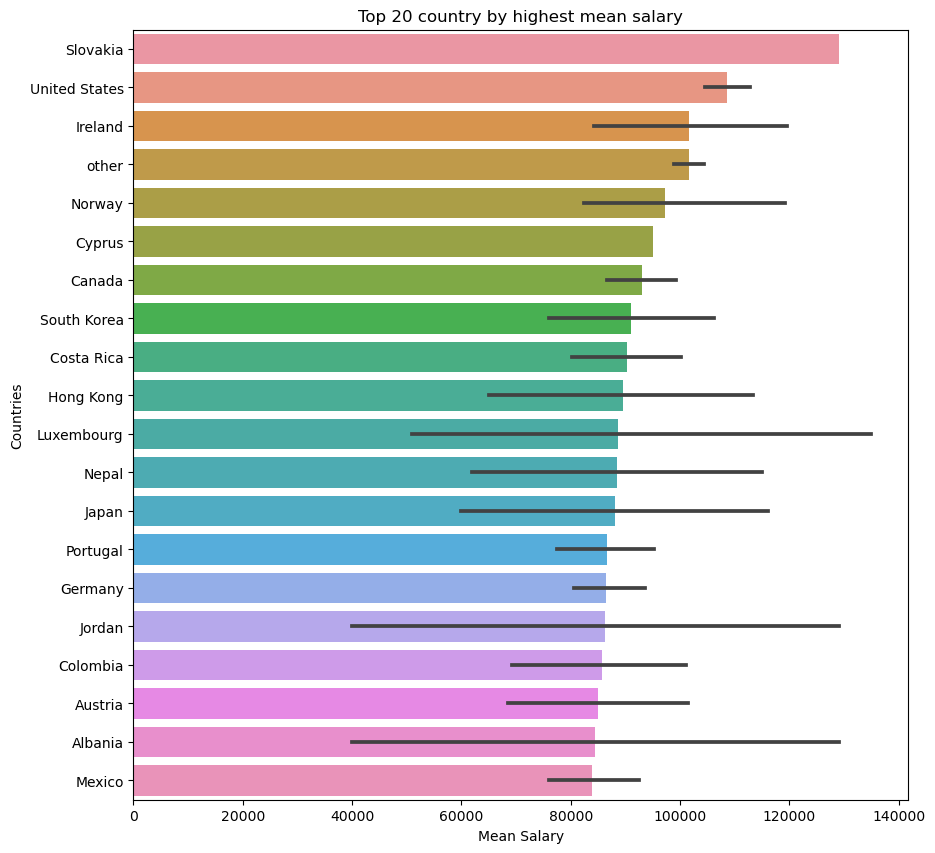

In [60]:
fig, ax = plt.subplots(figsize=(10,10)) 
ax=sns.barplot(data=dfv01.loc[dfv01.Countries.isin(df_country_salary['Countries'])],
               y='Countries' ,x='Salary_num', order=df_country_salary.Countries)
plt.xlabel('Mean Salary')
plt.ylabel('Countries')
plt.title("Top 20 country by highest mean salary")

Text(0.5, 0.98, 'Top 20 country by highest mean salary; Experience breakdown')

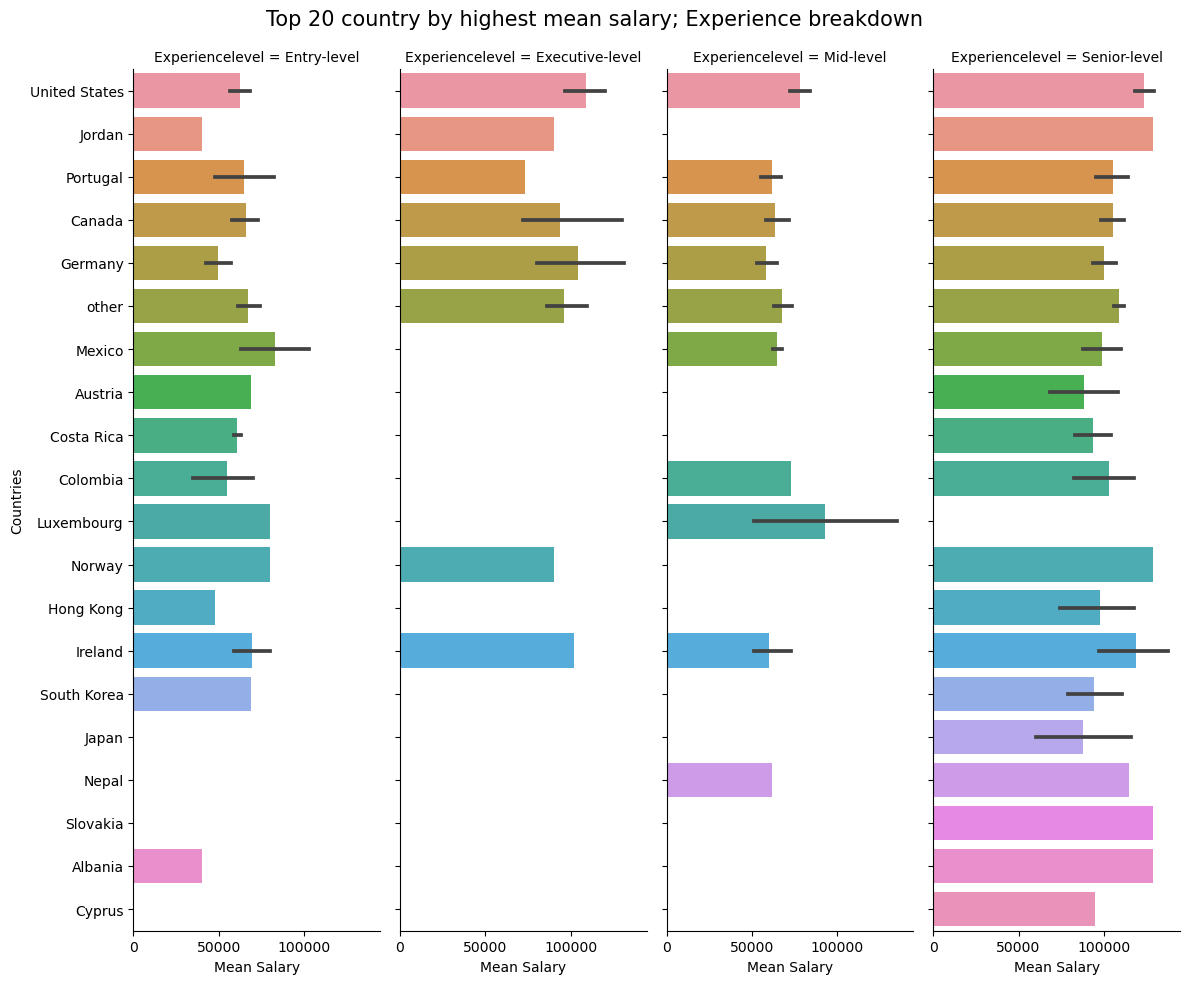

In [61]:
g=sns.catplot(data=dfv01.loc[dfv01.Countries.isin(df_country_salary['Countries'])],
               y='Countries' ,x='Salary_num',height=10, aspect=0.3, kind="bar", 
              col= 'Experiencelevel').set_axis_labels("Mean Salary" ,"Countries")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Top 20 country by highest mean salary; Experience breakdown', size=15)

# City based observations

Text(0.5, 1.0, 'Number of Job by City')

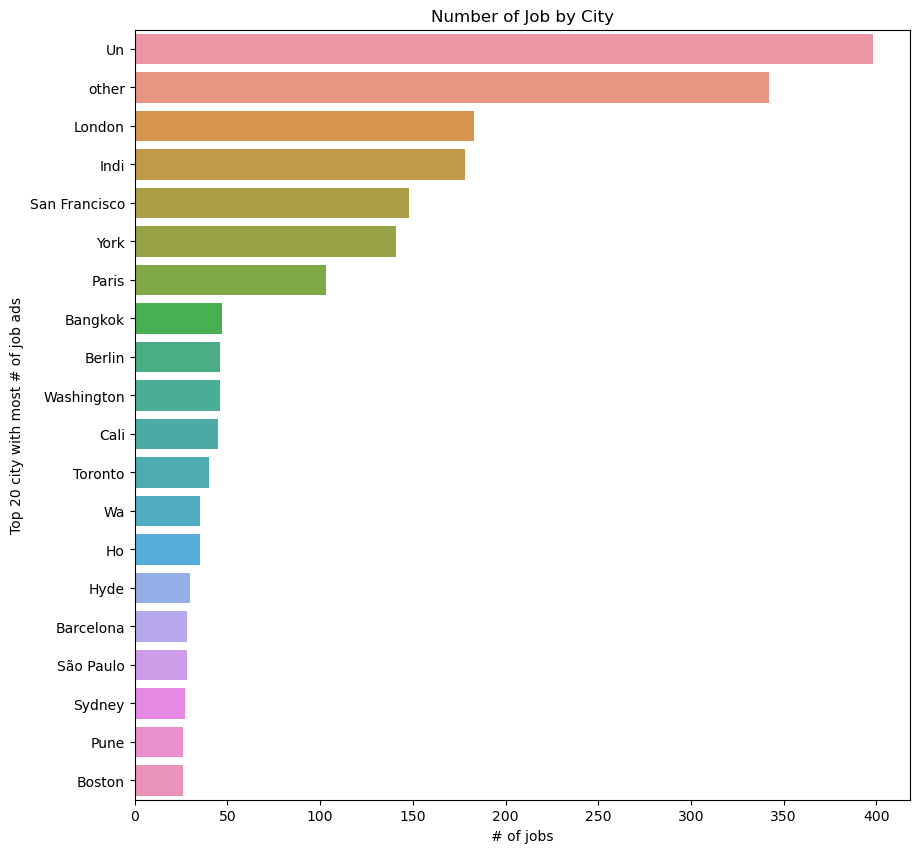

In [62]:
df_city=dfv01['Cities'].value_counts().reset_index().head(20)
fig, ax = plt.subplots(figsize=(10,10)) 
ax=sns.barplot(data=df_city, y='index' ,x='Cities')
plt.xlabel('# of jobs')
plt.ylabel('Top 20 city with most # of job ads')
plt.title("Number of Job by City")

Text(0.5, 0.98, 'Top 20 city with most # of job ads; Experience breakdown')

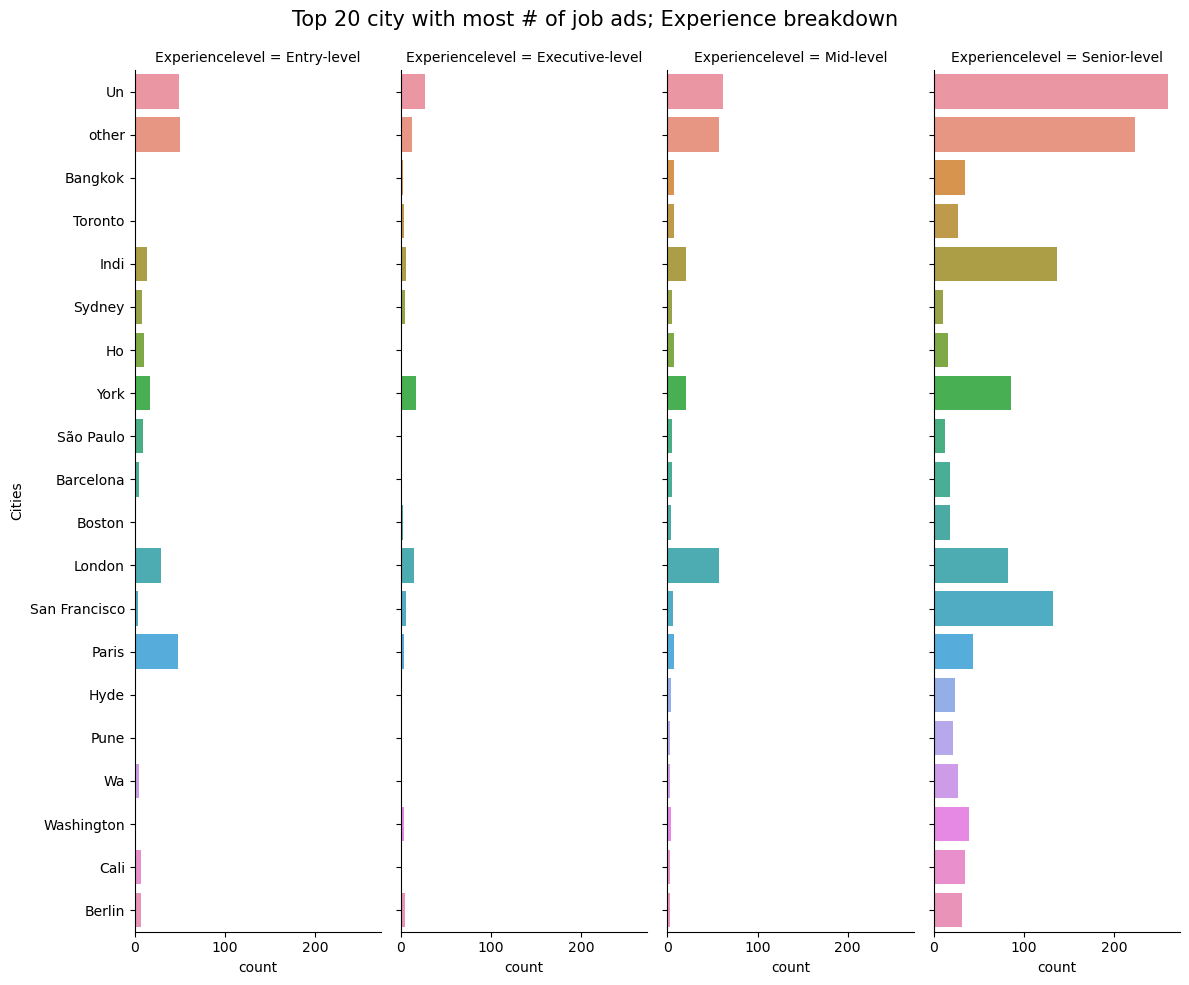

In [63]:
g=sns.catplot(data=dfv01.loc[dfv01.Cities.isin(df_city['index'])], height=10, aspect=0.3,
              y='Cities' ,kind="count",col= 'Experiencelevel')
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Top 20 city with most # of job ads; Experience breakdown', size=15)

In [64]:
df_city_salary=dfv01.groupby('Cities')['Salary_num'].mean().reset_index().sort_values(by=['Salary_num'], 
                                                                                            ascending=False).head(20)

Text(0.5, 1.0, 'Top 20 city by highest mean salary')

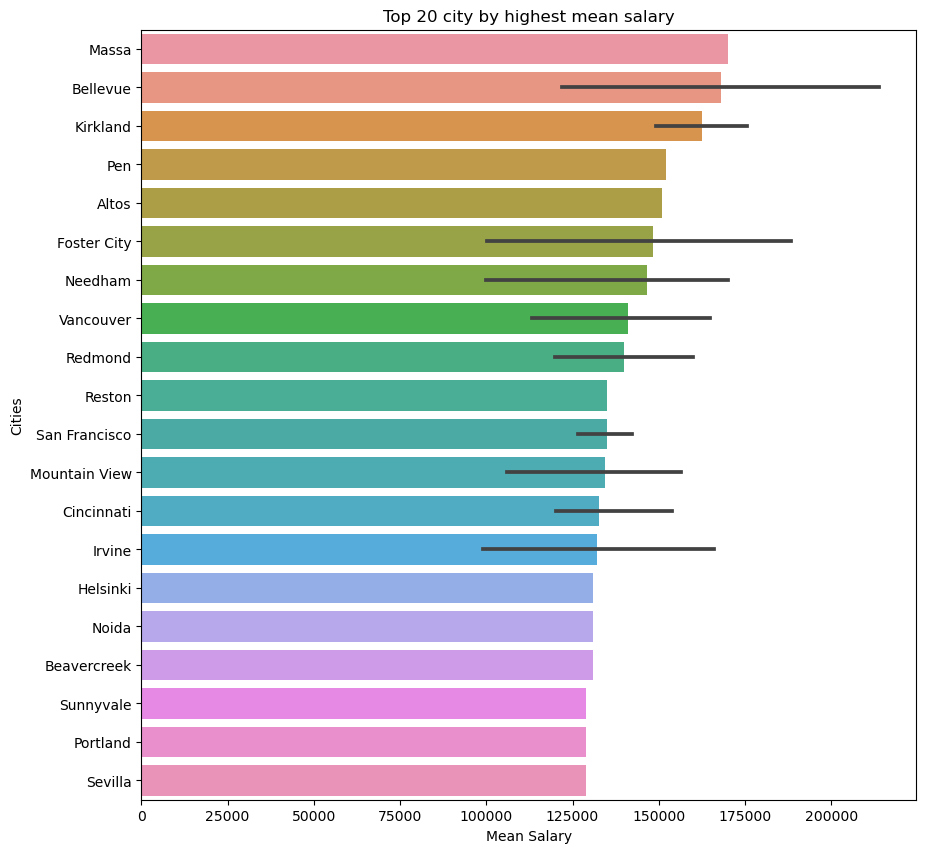

In [65]:
fig, ax = plt.subplots(figsize=(10,10)) 
ax=sns.barplot(data=dfv01.loc[dfv01.Cities.isin(df_city_salary['Cities'])],
               y='Cities' ,x='Salary_num', order=df_city_salary.Cities)
plt.xlabel('Mean Salary')
plt.ylabel('Cities')
plt.title("Top 20 city by highest mean salary")

Text(0.5, 0.98, 'Top 20 city by highest mean salary; Experience breakdown')

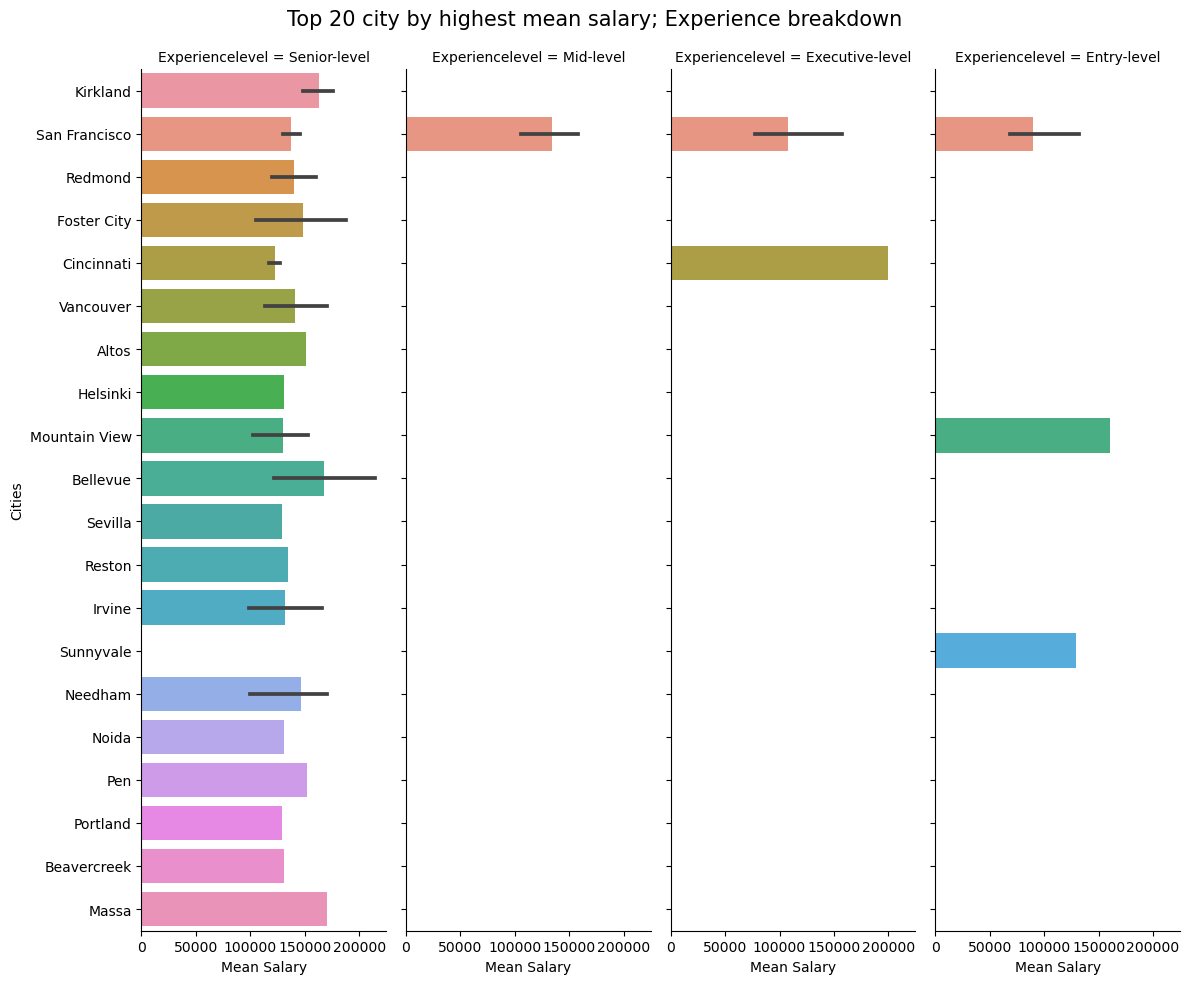

In [66]:
g=sns.catplot(data=dfv01.loc[dfv01.Cities.isin(df_city_salary['Cities'])],
               y='Cities' ,x='Salary_num',height=10, aspect=0.3, kind="bar", 
              col= 'Experiencelevel').set_axis_labels("Mean Salary" ,"Cities")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Top 20 city by highest mean salary; Experience breakdown', size=15)

# Job Title Based Observations

Text(0.5, 1.0, 'Number of Job by JobTitles')

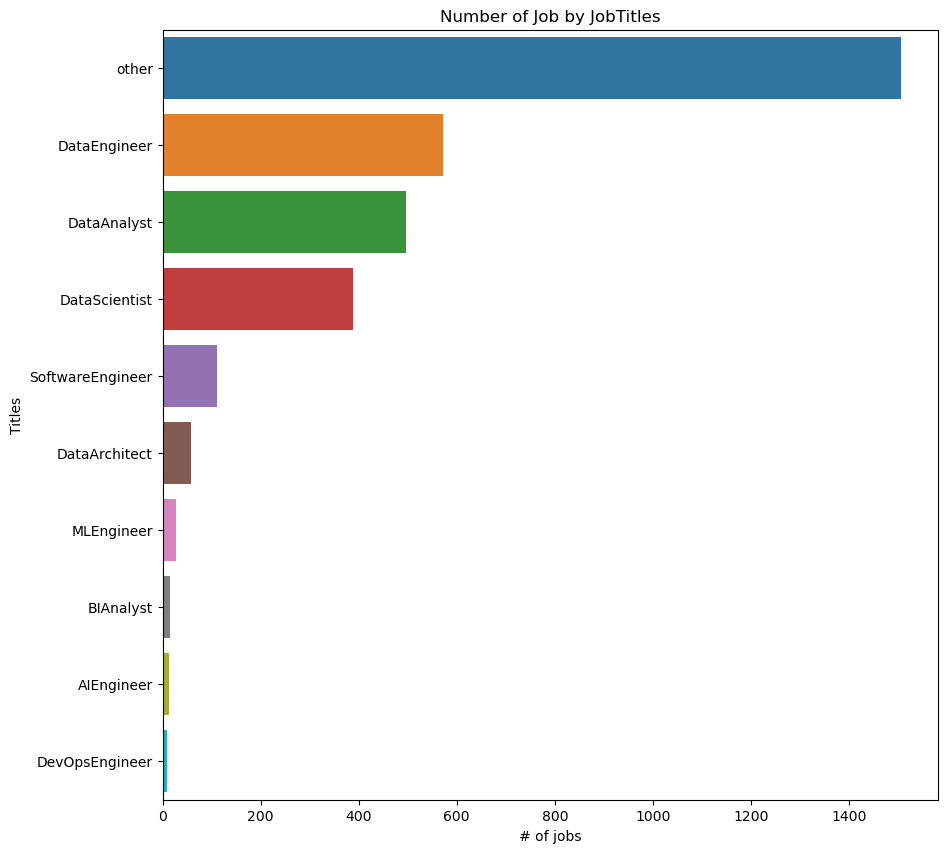

In [67]:
df_title=dfv01['JobTitle_Unique'].value_counts().reset_index()
fig, ax = plt.subplots(figsize=(10,10)) 
ax=sns.barplot(data=df_title, y='index' ,x='JobTitle_Unique')
plt.xlabel('# of jobs')
plt.ylabel('Titles')
plt.title("Number of Job by JobTitles")

Text(0.5, 0.98, 'Number of Job by JobTitle; Experience breakdown')

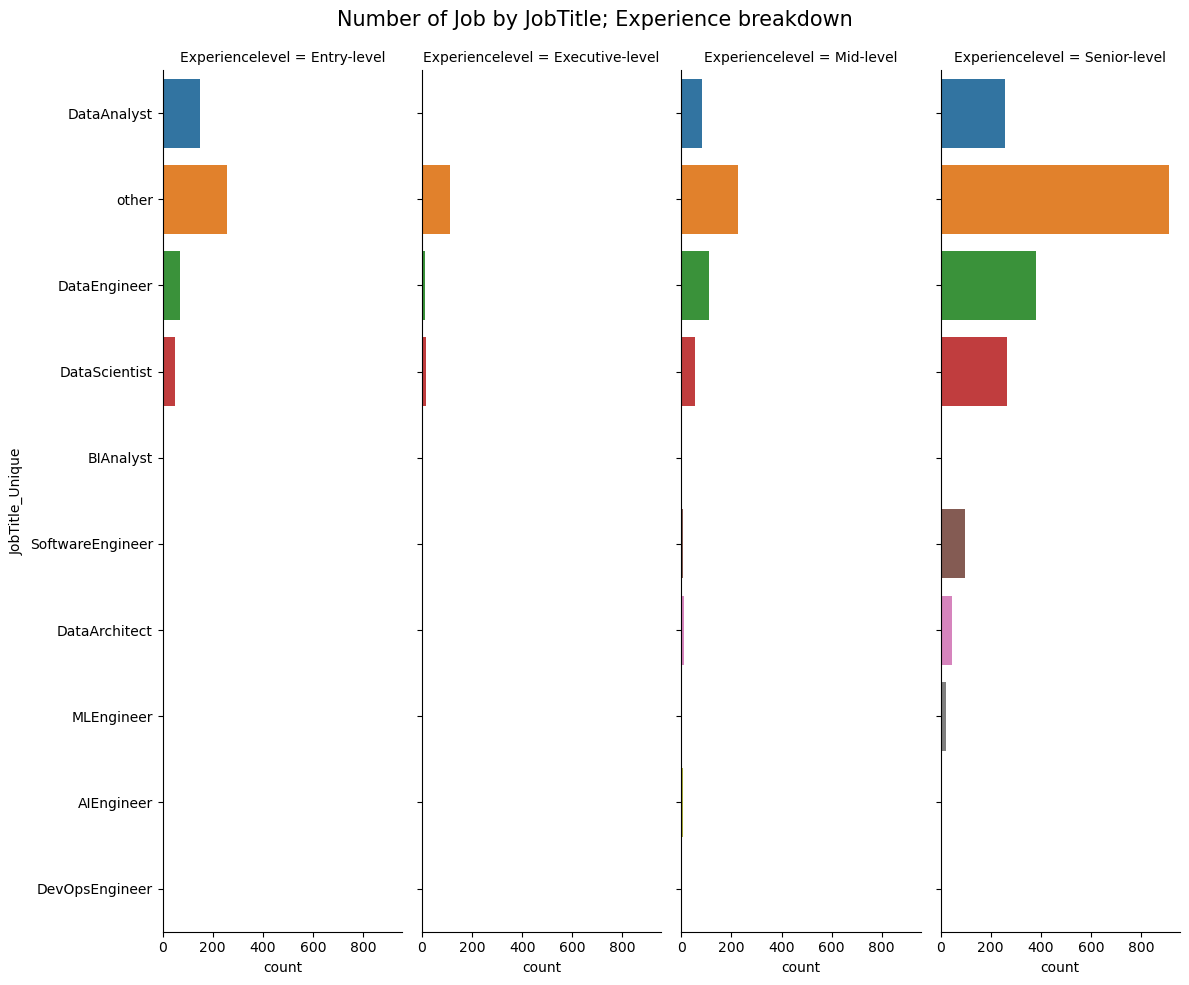

In [68]:
g=sns.catplot(data=dfv01.loc[dfv01.JobTitle_Unique.isin(df_title['index'])], height=10, aspect=0.3,
              y='JobTitle_Unique' ,kind="count",col= 'Experiencelevel')
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Number of Job by JobTitle; Experience breakdown', size=15)

In [69]:
df_title_salary=dfv01.groupby('JobTitle_Unique')['Salary_num'].mean().reset_index().sort_values(by=['Salary_num'], 
                                                                                            ascending=False).head(20)

Text(0.5, 1.0, 'Job Titles by highest mean salary')

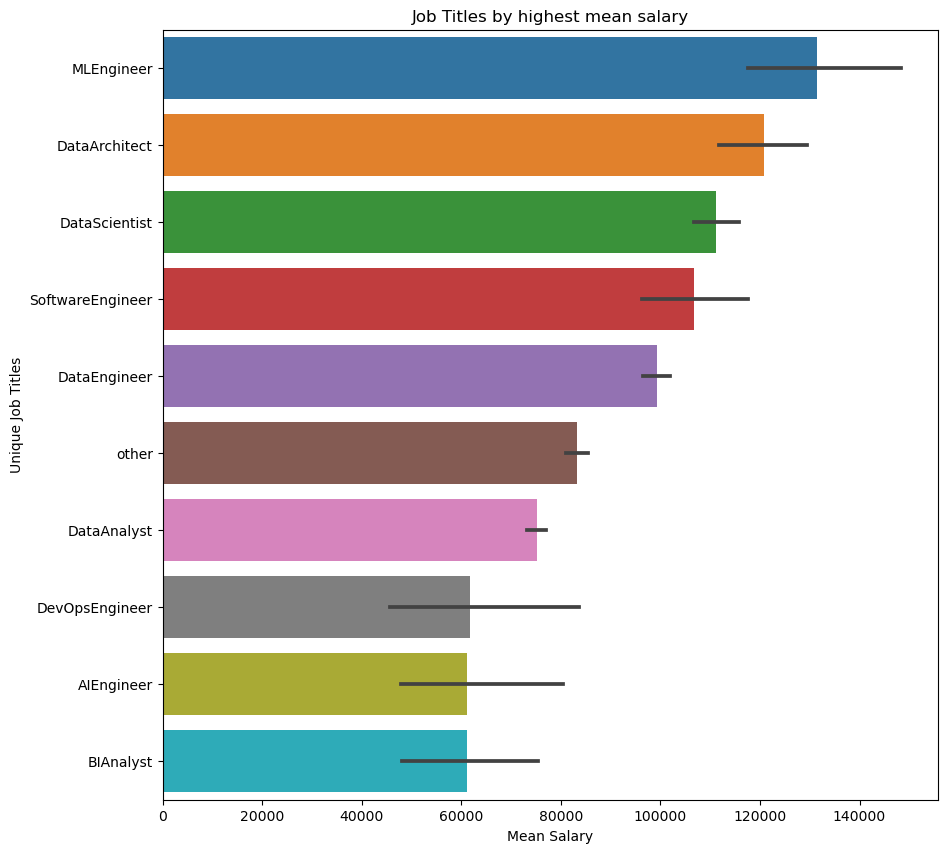

In [70]:
fig, ax = plt.subplots(figsize=(10,10)) 
ax=sns.barplot(data=dfv01.loc[dfv01.JobTitle_Unique.isin(df_title_salary['JobTitle_Unique'])],
               y='JobTitle_Unique' ,x='Salary_num', order=df_title_salary.JobTitle_Unique)
plt.xlabel('Mean Salary')
plt.ylabel('Unique Job Titles')
plt.title("Job Titles by highest mean salary")

Text(0.5, 0.98, 'Job Titles by highest mean salary; Experience breakdown')

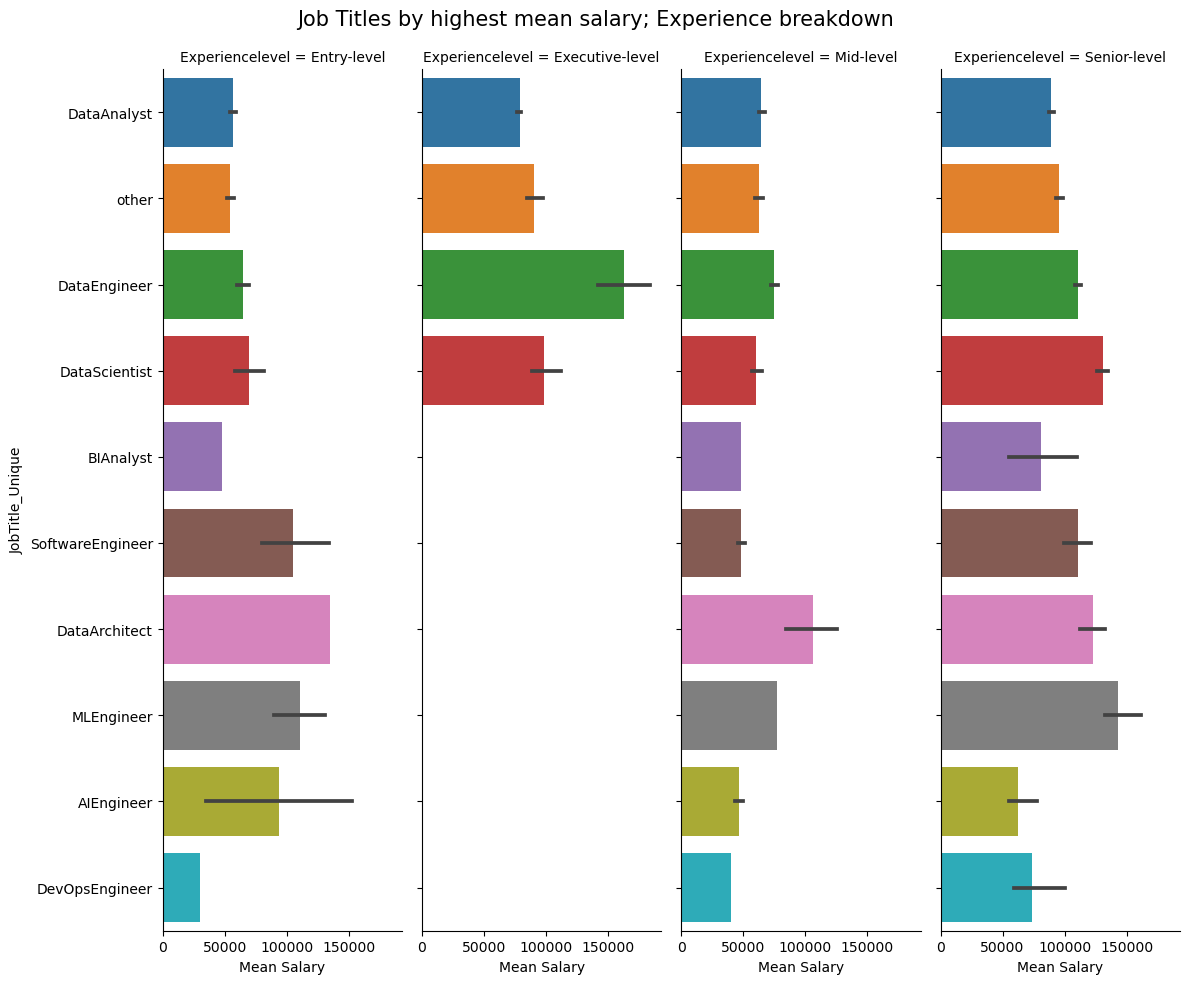

In [71]:
g=sns.catplot(data=dfv01.loc[dfv01.JobTitle_Unique.isin(df_title_salary['JobTitle_Unique'])],
               y='JobTitle_Unique' ,x='Salary_num',height=10, aspect=0.3, kind="bar", 
              col= 'Experiencelevel').set_axis_labels("Mean Salary" ,"JobTitle_Unique")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Job Titles by highest mean salary; Experience breakdown', size=15)